In [1]:
# function to reshape features into (samples, time steps, features)
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def gen_sequence(id_df, seq_length, seq_cols):
    # Only sequences that meet the window-length are considered, no padding is used. This means for testing
    # we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    # we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

    # function to generate labels


def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]


# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :].reshape(-1)


# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape_append1(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield np.append(data_array[start:stop, :].reshape(-1), 1)


# Gradient Solvers for FSVRG in aggregation shape (d,N
def compute_gradient_FSVRG(w, X, Y, lambda_):
    # returns a matrix of shape (d, N)
    N, d = X.shape
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y * X  # (N, d)

    return YX_neg.reshape(d, N) + 2 * lambda_ * w  # (d, N)


# Gradient Solvers
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y * X  # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T / N

    reg = 2 * lambda_ * w
    #     set_trace()

    return g + reg


# Compute hingeloss
def hinge_loss(w, X, Y):
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d, 1)
    assert Y.shape == (N, 1)
    L = 1 - Y * (X @ w)  # (N,1)
    L[L < 0] = 0
    return L


# Cost
def cost(w, X, Y):
    return np.sum(hinge_loss(w, X, Y))


# Predict
def predict(w, X):
    return np.sign(X @ w)


# Accuracy
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects / N


# Def solver
def solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
           mini_batch=100, mem=False, return_cost=False, verbose=True, seed=-1,
           p_val=0, R_val=0, iter_print=False, T_FSVRG=1):
    N_workers = len(X)
    N_workers, N, dw = np.shape(X)
    dw = w.shape[0]

    noise_std = R_val ** 0.5

    if seed != -1:
        np.random.seed(seed)

    cost_ = np.zeros(num_iters + 1)
    acc_ = np.zeros(num_iters + 1)

    if return_cost:
        cost_[0] = cost(w, X_test, Y_test)  # return the first element in cost
        acc_[0] = accuracy(w, X_test, Y_test)  # Return the first element in accuracy

    if (optimizer == "GD"):
        g_ = np.zeros(shape=(dw, N_workers))
        for i in range(num_iters):
            if iter_print:
                print("..... num_iters =", i, "......")
            for worker_i in range(N_workers):
                #                 set_trace()
                gi = compute_gradient(w, X[worker_i], Y[worker_i], lambda_) \
                     + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # , size=(dw, 1)
                g_[:, worker_i] = gi.flatten()
            g = np.sum(g_, axis=1, keepdims=1)
            w = w - alpha * g / N_workers  # GD update

            if return_cost:
                cost_[i + 1] = cost(w, X[0], Y[0])
                acc_[i + 1] = accuracy(w, X_test, Y_test)

        if (verbose):
            print("GD: Number of iterations: ", num_iters, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))


    elif (optimizer == "SGD"):
        g_ = np.zeros(shape=(dw, N_workers))
        for i in range(num_iters):
            if iter_print:
                print("..... num_iters_SGD =", i, "......")
            for worker_i in range(N_workers):
                N, d = X[worker_i].shape
                i_ = int(N * np.random.rand(1))
                X_ = X[worker_i][[i_], :]
                Y_ = Y[worker_i][[i_], :]

                gi = compute_gradient(w, X_, Y_, lambda_) \
                     + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # , size=(dw, 1)

                g_[:, worker_i] = gi.flatten()
            g = np.sum(g_, axis=1, keepdims=1)
            w = w - alpha * g / N_workers  # SGD update

            if return_cost:
                cost_[i + 1] = cost(w, X[0], Y[0])
                acc_[i + 1] = accuracy(w, X_test, Y_test)

        if (verbose):
            print("SGD: Number of iterations: ", num_iters, "/", num_iters)
            print("SGD: final norm: ", np.linalg.norm(g))


    elif (optimizer == "FSVRG"):
        T = T_FSVRG
        # epoch length
        K = math.floor(num_iters / T)
        # number of epochs, given number of iteration
        if K == 0:
            # only run for one epoch consisting of num_iters iterations
            K = 1
            T = num_iters

        # Aggregation of all gradients from the workes
        G_vec = np.zeros(shape=(dw, N))  # (d, N)
        w_k = np.zeros(shape=(dw, N_workers))  # (d, N_workers)

        for i in range(num_iters):

            for worker_i in range(N_workers):
                N, d = X[worker_i].shape
                X_ = X[worker_i]
                Y_ = Y[worker_i]
                gi = compute_gradient_FSVRG(w, X_, Y_, lambda_) \
                     + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # (d, N) , size=(dw, N)

                G_vec = G_vec + gi  # aggregation of gradients in server

            G_vec = ((1 / N_workers) * G_vec) \
                    + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # (d, N) , size=(dw, N)
            G_ = (1 / N) * np.sum(G_vec, axis=1, keepdims=1)  # (d, 1)

            for worker_i in range(N_workers):
                w_k[:, worker_i] = w[:, 0]
                for t in range(T):
                    i_ = int(N * np.random.rand(1))
                    X_ = X[worker_i][[i_], :]  # (1, d)
                    Y_ = Y[worker_i][[i_], :]  # (1, 1)

                    g = compute_gradient(w, X_, Y_, lambda_)  # (d, 1)

                    assert g.shape == (dw, 1)
                    assert G_vec[:, [i_]].shape == (dw, 1)
                    assert G_.shape == (dw, 1)

                    w_k[:, worker_i] = w_k[:, worker_i] - alpha * (g - G_vec[:, [i_]] + G_).reshape(dw)
            w_k = w_k + (np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)) / 2000
            w = (1 / N_workers) * np.sum(w_k, axis=1, keepdims=1)

            if return_cost:
                cost_[i + 1] = cost(w, X[0], Y[0])
                acc_[i + 1] = accuracy(w, X_test, Y_test)

            if (verbose):
                print("FSVRG: Number of iterations: ", i, "/", num_iters)
                print("FSVRG: final norm: ", np.linalg.norm(g - G_vec[:, [i_]] + G_))

    if return_cost:
        return cost_, w, acc_



In [2]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHGSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace

#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM, Activation

import time
import math
import sys

# the "resource" library is not available on windows.
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource

    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

train_df = pd.read_csv('train_FD004.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']
########################################################################################################################
train_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
train_df.head()
########################################################################################################################
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()
########################################################################################################################
w1 = 50
w0 = 30
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, -1)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()
########################################################################################################################
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)
train_df.head()
########################################################################################################################
clipResponse = True
if clipResponse:
    rulThreshold = 150
    for i in range(len(train_df['RUL'])):
        train_df.loc[i, 'RUL'] = min(train_df.loc[i, 'RUL'], rulThreshold)
train_df.head()
########################################################################################################################
train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()
train_df.shape
########################################################################################################################
test_df = pd.read_csv('test_FD004.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()
########################################################################################################################
test_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
test_df.head()
########################################################################################################################
truth_df = pd.read_csv('RUL_FD004.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()
########################################################################################################################
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()
########################################################################################################################
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)
########################################################################################################################
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()
########################################################################################################################
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, -1)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()
test_df.shape
########################################################################################################################
column_order = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
                's14', 's15', 's17', 's20', 's21', 'RUL', 'label1', 'label2', 'cycle_norm']

test_df = test_df.reindex(columns=column_order)

Failed on importing 'resource' package, continuing wihtout it!


In [3]:
sequence_length = 20
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's7', 's8', 's9', 's11']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 2, 3, 4, 7, 8, 9, 11
# ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 12, 13, 14, 15, 17, 20, 21
# ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))
########################################################################################################################
# pick the feature columns
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)
########################################################################################################################
# Train data
# generator train data for the sequences for each agent and save in a list
data_array_ = {}
for i in train_df['id'].unique():
    seq_gen_ = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length, sequence_cols)) for id in [i])
    data_array_[i] = np.concatenate(list(seq_gen_)).astype(np.float32)
print(len(data_array_))
########################################################################################################################
label_array_ = {}
# generate train labels for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_ = (gen_labels(train_df[train_df['id'] == id], sequence_length, ['label1']) for id in [i])
    label_array_[i] = np.concatenate(list(label_gen_)).astype(np.float32)
########################################################################################################################
label_array_rul_ = {}
# Generate train labels based on RUL for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_rul_ = (gen_labels(train_df[train_df['id'] == id], sequence_length, ['RUL']) for id in [i])
    label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)
########################################################################################################################
# Find the minimum length of dataset for each agent
min_length = label_array_rul_[1].shape[0]
for i in train_df['id'].unique():
    if min_length > label_array_rul_[i].shape[0]:
        min_length = label_array_rul_[i].shape[0]
########################################################################################################################
# set all length of lists to the minimum length of arrays
for i in train_df['id'].unique():
    label_array_rul_[i] = label_array_rul_[i][len(label_array_rul_[i]) - min_length:, :]
    label_array_[i] = label_array_[i][len(label_array_[i]) - min_length:, :]
    data_array_[i] = data_array_[i][len(data_array_[i]) - min_length:, :, :]

print(len(data_array_))
print(len(label_array_))
print(len(label_array_rul_))

print(data_array_[1].shape)
print(label_array_[1].shape)
print(label_array_rul_[1].shape)

249
249
249
249
(108, 20, 17)
(108, 1)
(108, 1)


In [4]:
########################################################################################################################
# Test Data
# generator test data for the sequences for each agent and save in a list
seq_array_test_ = {}
for i in test_df['id'].unique():
    seq_gen_test_ = (list(gen_sequence(test_df[test_df['id'] == id], sequence_length, sequence_cols)) for id in
                     [i])
    seq_array_test_[i] = np.concatenate(list(seq_gen_test_)).astype(np.float32)
########################################################################################################################
label_array_test_ = {}
# generatAe test labels for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_ = (gen_labels(test_df[test_df['id'] == id], sequence_length, ['label1']) for id in [i])
    label_array_test_[i] = np.concatenate(list(label_gen_test_)).astype(np.float32)
########################################################################################################################
label_array_test_rul_ = {}
# Generate test labels based on RUL for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_rul_ = (gen_labels(test_df[test_df['id'] == id], sequence_length, ['RUL']) for id in [i])
    label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)
########################################################################################################################
seq_array_test_tmp = {}
label_array_test_tmp = {}
label_array_test_rul_tmp = {}
for i in test_df['id'].unique():
    tmp = seq_array_test_[i].shape[0]
    if tmp >= min_length:
        seq_array_test_tmp[i] = seq_array_test_[i]
        label_array_test_tmp[i] = label_array_test_[i]
        label_array_test_rul_tmp[i] = label_array_test_rul_[i]
########################################################################################################################
# change the key of dictionary and indexing it based on increasing number from 1
seq_array_test_ = {}
label_array_test_ = {}
label_array_test_rul_ = {}
j = 1
for i in seq_array_test_tmp.keys():
    seq_array_test_[j] = seq_array_test_tmp[i]
    label_array_test_[j] = label_array_test_tmp[i]
    label_array_test_rul_[j] = label_array_test_rul_tmp[i]
    j += 1

del seq_array_test_tmp
del label_array_test_tmp
del label_array_test_rul_tmp

# set all length of test lists to the minimum length of arrays (min_length)
for i in seq_array_test_.keys():
    label_array_test_rul_[i] = label_array_test_rul_[i][len(label_array_test_rul_[i]) - min_length:, :]
    label_array_test_[i] = label_array_test_[i][len(label_array_test_[i]) - min_length:, :]
    seq_array_test_[i] = seq_array_test_[i][len(seq_array_test_[i]) - min_length:, :, :]

print(len(seq_array_test_))
print(len(label_array_test_))
print(len(label_array_test_rul_))

print(seq_array_test_[1].shape)
print(label_array_test_[1].shape)
print(label_array_test_rul_[1].shape)

X_dic = {}
Y_dic = {}
Y_rul_dic = {}
for i in data_array_.keys():
    X_dic[i - 1] = data_array_[i].reshape(min_length, -1)
    Y_dic[i - 1] = label_array_[i]
    Y_rul_dic[i - 1] = label_array_rul_[i]

X_test_dic = {}
Y_test_dic = {}
Y_test_rul_dic = {}
for i in seq_array_test_.keys():
    X_test_dic[i - 1] = seq_array_test_[i].reshape(min_length, -1)
    Y_test_dic[i - 1] = label_array_test_[i]
    Y_test_rul_dic[i - 1] = label_array_test_rul_[i]

151
151
151
(108, 20, 17)
(108, 1)
(108, 1)


In [5]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
num_workers = 10
# Select random workers
index = [rand_num for rand_num in [random.randrange(*sorted([0, len(X_dic)])) for i in range(len(X_dic))]]
index = np.array(index)
index = index.reshape(-1, 1)
index = index[0:math.floor(len(data_array_)/num_workers)*num_workers, :]
index = index.reshape(-1, num_workers)
X = [np.concatenate(([X_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
Y = [np.concatenate(([Y_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
Y_rul = [np.concatenate(([Y_rul_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
#X = [X_dic[i] for i in index]
#Y = [Y_dic[i] for i in index]
#Y_rul = [Y_rul_dic[i] for i in index]


X_test = np.array([[X_test_dic[i]] for i in range(len(X_test_dic))]).reshape(-1, X_test_dic[0].shape[1])
Y_test = np.array([[Y_test_dic[i]] for i in range(len(X_test_dic))]).reshape(-1, Y_test_dic[0].shape[1])
print(X_test.shape)
print(Y_test.shape)

(16308, 340)
(16308, 1)


In [6]:
d = X[0].shape[1]
w = np.random.rand(d, 1)
alpha = 0.01
num_iters = 3000
lambda_ = 0.1
epsilon = 0
p_val = 0
R_val = 0

In [7]:
########################################################################################################################
# Run GD
time1 = time.time()
cost_GD, w_out_GD, acc_GD = solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime GD num_iters=", time2 - time1)
print("final cost with GD", cost_GD[-1])
acc_final_GD= accuracy(w_out_GD, X_test, Y_test)
print("final acc with 10 workers FedSVM_GD:", acc_final_GD)
print("-------------------------------------")


..... num_iters = 0 ......
..... num_iters = 1 ......
..... num_iters = 2 ......
..... num_iters = 3 ......
..... num_iters = 4 ......
..... num_iters = 5 ......
..... num_iters = 6 ......
..... num_iters = 7 ......
..... num_iters = 8 ......
..... num_iters = 9 ......
..... num_iters = 10 ......
..... num_iters = 11 ......
..... num_iters = 12 ......
..... num_iters = 13 ......
..... num_iters = 14 ......
..... num_iters = 15 ......
..... num_iters = 16 ......
..... num_iters = 17 ......
..... num_iters = 18 ......
..... num_iters = 19 ......
..... num_iters = 20 ......
..... num_iters = 21 ......
..... num_iters = 22 ......
..... num_iters = 23 ......
..... num_iters = 24 ......
..... num_iters = 25 ......
..... num_iters = 26 ......
..... num_iters = 27 ......
..... num_iters = 28 ......
..... num_iters = 29 ......
..... num_iters = 30 ......
..... num_iters = 31 ......
..... num_iters = 32 ......
..... num_iters = 33 ......
..... num_iters = 34 ......
..... num_iters = 35 ......
..

..... num_iters = 287 ......
..... num_iters = 288 ......
..... num_iters = 289 ......
..... num_iters = 290 ......
..... num_iters = 291 ......
..... num_iters = 292 ......
..... num_iters = 293 ......
..... num_iters = 294 ......
..... num_iters = 295 ......
..... num_iters = 296 ......
..... num_iters = 297 ......
..... num_iters = 298 ......
..... num_iters = 299 ......
..... num_iters = 300 ......
..... num_iters = 301 ......
..... num_iters = 302 ......
..... num_iters = 303 ......
..... num_iters = 304 ......
..... num_iters = 305 ......
..... num_iters = 306 ......
..... num_iters = 307 ......
..... num_iters = 308 ......
..... num_iters = 309 ......
..... num_iters = 310 ......
..... num_iters = 311 ......
..... num_iters = 312 ......
..... num_iters = 313 ......
..... num_iters = 314 ......
..... num_iters = 315 ......
..... num_iters = 316 ......
..... num_iters = 317 ......
..... num_iters = 318 ......
..... num_iters = 319 ......
..... num_iters = 320 ......
..... num_iter

..... num_iters = 570 ......
..... num_iters = 571 ......
..... num_iters = 572 ......
..... num_iters = 573 ......
..... num_iters = 574 ......
..... num_iters = 575 ......
..... num_iters = 576 ......
..... num_iters = 577 ......
..... num_iters = 578 ......
..... num_iters = 579 ......
..... num_iters = 580 ......
..... num_iters = 581 ......
..... num_iters = 582 ......
..... num_iters = 583 ......
..... num_iters = 584 ......
..... num_iters = 585 ......
..... num_iters = 586 ......
..... num_iters = 587 ......
..... num_iters = 588 ......
..... num_iters = 589 ......
..... num_iters = 590 ......
..... num_iters = 591 ......
..... num_iters = 592 ......
..... num_iters = 593 ......
..... num_iters = 594 ......
..... num_iters = 595 ......
..... num_iters = 596 ......
..... num_iters = 597 ......
..... num_iters = 598 ......
..... num_iters = 599 ......
..... num_iters = 600 ......
..... num_iters = 601 ......
..... num_iters = 602 ......
..... num_iters = 603 ......
..... num_iter

..... num_iters = 853 ......
..... num_iters = 854 ......
..... num_iters = 855 ......
..... num_iters = 856 ......
..... num_iters = 857 ......
..... num_iters = 858 ......
..... num_iters = 859 ......
..... num_iters = 860 ......
..... num_iters = 861 ......
..... num_iters = 862 ......
..... num_iters = 863 ......
..... num_iters = 864 ......
..... num_iters = 865 ......
..... num_iters = 866 ......
..... num_iters = 867 ......
..... num_iters = 868 ......
..... num_iters = 869 ......
..... num_iters = 870 ......
..... num_iters = 871 ......
..... num_iters = 872 ......
..... num_iters = 873 ......
..... num_iters = 874 ......
..... num_iters = 875 ......
..... num_iters = 876 ......
..... num_iters = 877 ......
..... num_iters = 878 ......
..... num_iters = 879 ......
..... num_iters = 880 ......
..... num_iters = 881 ......
..... num_iters = 882 ......
..... num_iters = 883 ......
..... num_iters = 884 ......
..... num_iters = 885 ......
..... num_iters = 886 ......
..... num_iter

..... num_iters = 1132 ......
..... num_iters = 1133 ......
..... num_iters = 1134 ......
..... num_iters = 1135 ......
..... num_iters = 1136 ......
..... num_iters = 1137 ......
..... num_iters = 1138 ......
..... num_iters = 1139 ......
..... num_iters = 1140 ......
..... num_iters = 1141 ......
..... num_iters = 1142 ......
..... num_iters = 1143 ......
..... num_iters = 1144 ......
..... num_iters = 1145 ......
..... num_iters = 1146 ......
..... num_iters = 1147 ......
..... num_iters = 1148 ......
..... num_iters = 1149 ......
..... num_iters = 1150 ......
..... num_iters = 1151 ......
..... num_iters = 1152 ......
..... num_iters = 1153 ......
..... num_iters = 1154 ......
..... num_iters = 1155 ......
..... num_iters = 1156 ......
..... num_iters = 1157 ......
..... num_iters = 1158 ......
..... num_iters = 1159 ......
..... num_iters = 1160 ......
..... num_iters = 1161 ......
..... num_iters = 1162 ......
..... num_iters = 1163 ......
..... num_iters = 1164 ......
..... num_

..... num_iters = 1407 ......
..... num_iters = 1408 ......
..... num_iters = 1409 ......
..... num_iters = 1410 ......
..... num_iters = 1411 ......
..... num_iters = 1412 ......
..... num_iters = 1413 ......
..... num_iters = 1414 ......
..... num_iters = 1415 ......
..... num_iters = 1416 ......
..... num_iters = 1417 ......
..... num_iters = 1418 ......
..... num_iters = 1419 ......
..... num_iters = 1420 ......
..... num_iters = 1421 ......
..... num_iters = 1422 ......
..... num_iters = 1423 ......
..... num_iters = 1424 ......
..... num_iters = 1425 ......
..... num_iters = 1426 ......
..... num_iters = 1427 ......
..... num_iters = 1428 ......
..... num_iters = 1429 ......
..... num_iters = 1430 ......
..... num_iters = 1431 ......
..... num_iters = 1432 ......
..... num_iters = 1433 ......
..... num_iters = 1434 ......
..... num_iters = 1435 ......
..... num_iters = 1436 ......
..... num_iters = 1437 ......
..... num_iters = 1438 ......
..... num_iters = 1439 ......
..... num_

..... num_iters = 1681 ......
..... num_iters = 1682 ......
..... num_iters = 1683 ......
..... num_iters = 1684 ......
..... num_iters = 1685 ......
..... num_iters = 1686 ......
..... num_iters = 1687 ......
..... num_iters = 1688 ......
..... num_iters = 1689 ......
..... num_iters = 1690 ......
..... num_iters = 1691 ......
..... num_iters = 1692 ......
..... num_iters = 1693 ......
..... num_iters = 1694 ......
..... num_iters = 1695 ......
..... num_iters = 1696 ......
..... num_iters = 1697 ......
..... num_iters = 1698 ......
..... num_iters = 1699 ......
..... num_iters = 1700 ......
..... num_iters = 1701 ......
..... num_iters = 1702 ......
..... num_iters = 1703 ......
..... num_iters = 1704 ......
..... num_iters = 1705 ......
..... num_iters = 1706 ......
..... num_iters = 1707 ......
..... num_iters = 1708 ......
..... num_iters = 1709 ......
..... num_iters = 1710 ......
..... num_iters = 1711 ......
..... num_iters = 1712 ......
..... num_iters = 1713 ......
..... num_

..... num_iters = 1956 ......
..... num_iters = 1957 ......
..... num_iters = 1958 ......
..... num_iters = 1959 ......
..... num_iters = 1960 ......
..... num_iters = 1961 ......
..... num_iters = 1962 ......
..... num_iters = 1963 ......
..... num_iters = 1964 ......
..... num_iters = 1965 ......
..... num_iters = 1966 ......
..... num_iters = 1967 ......
..... num_iters = 1968 ......
..... num_iters = 1969 ......
..... num_iters = 1970 ......
..... num_iters = 1971 ......
..... num_iters = 1972 ......
..... num_iters = 1973 ......
..... num_iters = 1974 ......
..... num_iters = 1975 ......
..... num_iters = 1976 ......
..... num_iters = 1977 ......
..... num_iters = 1978 ......
..... num_iters = 1979 ......
..... num_iters = 1980 ......
..... num_iters = 1981 ......
..... num_iters = 1982 ......
..... num_iters = 1983 ......
..... num_iters = 1984 ......
..... num_iters = 1985 ......
..... num_iters = 1986 ......
..... num_iters = 1987 ......
..... num_iters = 1988 ......
..... num_

..... num_iters = 2231 ......
..... num_iters = 2232 ......
..... num_iters = 2233 ......
..... num_iters = 2234 ......
..... num_iters = 2235 ......
..... num_iters = 2236 ......
..... num_iters = 2237 ......
..... num_iters = 2238 ......
..... num_iters = 2239 ......
..... num_iters = 2240 ......
..... num_iters = 2241 ......
..... num_iters = 2242 ......
..... num_iters = 2243 ......
..... num_iters = 2244 ......
..... num_iters = 2245 ......
..... num_iters = 2246 ......
..... num_iters = 2247 ......
..... num_iters = 2248 ......
..... num_iters = 2249 ......
..... num_iters = 2250 ......
..... num_iters = 2251 ......
..... num_iters = 2252 ......
..... num_iters = 2253 ......
..... num_iters = 2254 ......
..... num_iters = 2255 ......
..... num_iters = 2256 ......
..... num_iters = 2257 ......
..... num_iters = 2258 ......
..... num_iters = 2259 ......
..... num_iters = 2260 ......
..... num_iters = 2261 ......
..... num_iters = 2262 ......
..... num_iters = 2263 ......
..... num_

..... num_iters = 2506 ......
..... num_iters = 2507 ......
..... num_iters = 2508 ......
..... num_iters = 2509 ......
..... num_iters = 2510 ......
..... num_iters = 2511 ......
..... num_iters = 2512 ......
..... num_iters = 2513 ......
..... num_iters = 2514 ......
..... num_iters = 2515 ......
..... num_iters = 2516 ......
..... num_iters = 2517 ......
..... num_iters = 2518 ......
..... num_iters = 2519 ......
..... num_iters = 2520 ......
..... num_iters = 2521 ......
..... num_iters = 2522 ......
..... num_iters = 2523 ......
..... num_iters = 2524 ......
..... num_iters = 2525 ......
..... num_iters = 2526 ......
..... num_iters = 2527 ......
..... num_iters = 2528 ......
..... num_iters = 2529 ......
..... num_iters = 2530 ......
..... num_iters = 2531 ......
..... num_iters = 2532 ......
..... num_iters = 2533 ......
..... num_iters = 2534 ......
..... num_iters = 2535 ......
..... num_iters = 2536 ......
..... num_iters = 2537 ......
..... num_iters = 2538 ......
..... num_

..... num_iters = 2781 ......
..... num_iters = 2782 ......
..... num_iters = 2783 ......
..... num_iters = 2784 ......
..... num_iters = 2785 ......
..... num_iters = 2786 ......
..... num_iters = 2787 ......
..... num_iters = 2788 ......
..... num_iters = 2789 ......
..... num_iters = 2790 ......
..... num_iters = 2791 ......
..... num_iters = 2792 ......
..... num_iters = 2793 ......
..... num_iters = 2794 ......
..... num_iters = 2795 ......
..... num_iters = 2796 ......
..... num_iters = 2797 ......
..... num_iters = 2798 ......
..... num_iters = 2799 ......
..... num_iters = 2800 ......
..... num_iters = 2801 ......
..... num_iters = 2802 ......
..... num_iters = 2803 ......
..... num_iters = 2804 ......
..... num_iters = 2805 ......
..... num_iters = 2806 ......
..... num_iters = 2807 ......
..... num_iters = 2808 ......
..... num_iters = 2809 ......
..... num_iters = 2810 ......
..... num_iters = 2811 ......
..... num_iters = 2812 ......
..... num_iters = 2813 ......
..... num_

In [40]:
########################################################################################################################
# Run SGD
time1 = time.time()
cost_SGD, w_out_SGD, acc_GD = solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="SGD",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime SGD num_iters=", time2 - time1)
print("final cost with SGD", cost_SGD[-1])
acc_final_SGD = accuracy(w_out_SGD, X_test, Y_test)
print("final acc with 10 workers FedSVM_SGD:", acc_final_SGD)
print("-------------------------------------")

..... num_iters_SGD = 0 ......
..... num_iters_SGD = 1 ......
..... num_iters_SGD = 2 ......
..... num_iters_SGD = 3 ......
..... num_iters_SGD = 4 ......
..... num_iters_SGD = 5 ......
..... num_iters_SGD = 6 ......
..... num_iters_SGD = 7 ......
..... num_iters_SGD = 8 ......
..... num_iters_SGD = 9 ......
..... num_iters_SGD = 10 ......
..... num_iters_SGD = 11 ......
..... num_iters_SGD = 12 ......
..... num_iters_SGD = 13 ......
..... num_iters_SGD = 14 ......
..... num_iters_SGD = 15 ......
..... num_iters_SGD = 16 ......
..... num_iters_SGD = 17 ......
..... num_iters_SGD = 18 ......
..... num_iters_SGD = 19 ......
..... num_iters_SGD = 20 ......
..... num_iters_SGD = 21 ......
..... num_iters_SGD = 22 ......
..... num_iters_SGD = 23 ......
..... num_iters_SGD = 24 ......
..... num_iters_SGD = 25 ......
..... num_iters_SGD = 26 ......
..... num_iters_SGD = 27 ......
..... num_iters_SGD = 28 ......
..... num_iters_SGD = 29 ......
..... num_iters_SGD = 30 ......
..... num_iters_SG

..... num_iters_SGD = 257 ......
..... num_iters_SGD = 258 ......
..... num_iters_SGD = 259 ......
..... num_iters_SGD = 260 ......
..... num_iters_SGD = 261 ......
..... num_iters_SGD = 262 ......
..... num_iters_SGD = 263 ......
..... num_iters_SGD = 264 ......
..... num_iters_SGD = 265 ......
..... num_iters_SGD = 266 ......
..... num_iters_SGD = 267 ......
..... num_iters_SGD = 268 ......
..... num_iters_SGD = 269 ......
..... num_iters_SGD = 270 ......
..... num_iters_SGD = 271 ......
..... num_iters_SGD = 272 ......
..... num_iters_SGD = 273 ......
..... num_iters_SGD = 274 ......
..... num_iters_SGD = 275 ......
..... num_iters_SGD = 276 ......
..... num_iters_SGD = 277 ......
..... num_iters_SGD = 278 ......
..... num_iters_SGD = 279 ......
..... num_iters_SGD = 280 ......
..... num_iters_SGD = 281 ......
..... num_iters_SGD = 282 ......
..... num_iters_SGD = 283 ......
..... num_iters_SGD = 284 ......
..... num_iters_SGD = 285 ......
..... num_iters_SGD = 286 ......
..... num_

..... num_iters_SGD = 506 ......
..... num_iters_SGD = 507 ......
..... num_iters_SGD = 508 ......
..... num_iters_SGD = 509 ......
..... num_iters_SGD = 510 ......
..... num_iters_SGD = 511 ......
..... num_iters_SGD = 512 ......
..... num_iters_SGD = 513 ......
..... num_iters_SGD = 514 ......
..... num_iters_SGD = 515 ......
..... num_iters_SGD = 516 ......
..... num_iters_SGD = 517 ......
..... num_iters_SGD = 518 ......
..... num_iters_SGD = 519 ......
..... num_iters_SGD = 520 ......
..... num_iters_SGD = 521 ......
..... num_iters_SGD = 522 ......
..... num_iters_SGD = 523 ......
..... num_iters_SGD = 524 ......
..... num_iters_SGD = 525 ......
..... num_iters_SGD = 526 ......
..... num_iters_SGD = 527 ......
..... num_iters_SGD = 528 ......
..... num_iters_SGD = 529 ......
..... num_iters_SGD = 530 ......
..... num_iters_SGD = 531 ......
..... num_iters_SGD = 532 ......
..... num_iters_SGD = 533 ......
..... num_iters_SGD = 534 ......
..... num_iters_SGD = 535 ......
..... num_

..... num_iters_SGD = 764 ......
..... num_iters_SGD = 765 ......
..... num_iters_SGD = 766 ......
..... num_iters_SGD = 767 ......
..... num_iters_SGD = 768 ......
..... num_iters_SGD = 769 ......
..... num_iters_SGD = 770 ......
..... num_iters_SGD = 771 ......
..... num_iters_SGD = 772 ......
..... num_iters_SGD = 773 ......
..... num_iters_SGD = 774 ......
..... num_iters_SGD = 775 ......
..... num_iters_SGD = 776 ......
..... num_iters_SGD = 777 ......
..... num_iters_SGD = 778 ......
..... num_iters_SGD = 779 ......
..... num_iters_SGD = 780 ......
..... num_iters_SGD = 781 ......
..... num_iters_SGD = 782 ......
..... num_iters_SGD = 783 ......
..... num_iters_SGD = 784 ......
..... num_iters_SGD = 785 ......
..... num_iters_SGD = 786 ......
..... num_iters_SGD = 787 ......
..... num_iters_SGD = 788 ......
..... num_iters_SGD = 789 ......
..... num_iters_SGD = 790 ......
..... num_iters_SGD = 791 ......
..... num_iters_SGD = 792 ......
..... num_iters_SGD = 793 ......
..... num_

..... num_iters_SGD = 1018 ......
..... num_iters_SGD = 1019 ......
..... num_iters_SGD = 1020 ......
..... num_iters_SGD = 1021 ......
..... num_iters_SGD = 1022 ......
..... num_iters_SGD = 1023 ......
..... num_iters_SGD = 1024 ......
..... num_iters_SGD = 1025 ......
..... num_iters_SGD = 1026 ......
..... num_iters_SGD = 1027 ......
..... num_iters_SGD = 1028 ......
..... num_iters_SGD = 1029 ......
..... num_iters_SGD = 1030 ......
..... num_iters_SGD = 1031 ......
..... num_iters_SGD = 1032 ......
..... num_iters_SGD = 1033 ......
..... num_iters_SGD = 1034 ......
..... num_iters_SGD = 1035 ......
..... num_iters_SGD = 1036 ......
..... num_iters_SGD = 1037 ......
..... num_iters_SGD = 1038 ......
..... num_iters_SGD = 1039 ......
..... num_iters_SGD = 1040 ......
..... num_iters_SGD = 1041 ......
..... num_iters_SGD = 1042 ......
..... num_iters_SGD = 1043 ......
..... num_iters_SGD = 1044 ......
..... num_iters_SGD = 1045 ......
..... num_iters_SGD = 1046 ......
..... num_iter

..... num_iters_SGD = 1260 ......
..... num_iters_SGD = 1261 ......
..... num_iters_SGD = 1262 ......
..... num_iters_SGD = 1263 ......
..... num_iters_SGD = 1264 ......
..... num_iters_SGD = 1265 ......
..... num_iters_SGD = 1266 ......
..... num_iters_SGD = 1267 ......
..... num_iters_SGD = 1268 ......
..... num_iters_SGD = 1269 ......
..... num_iters_SGD = 1270 ......
..... num_iters_SGD = 1271 ......
..... num_iters_SGD = 1272 ......
..... num_iters_SGD = 1273 ......
..... num_iters_SGD = 1274 ......
..... num_iters_SGD = 1275 ......
..... num_iters_SGD = 1276 ......
..... num_iters_SGD = 1277 ......
..... num_iters_SGD = 1278 ......
..... num_iters_SGD = 1279 ......
..... num_iters_SGD = 1280 ......
..... num_iters_SGD = 1281 ......
..... num_iters_SGD = 1282 ......
..... num_iters_SGD = 1283 ......
..... num_iters_SGD = 1284 ......
..... num_iters_SGD = 1285 ......
..... num_iters_SGD = 1286 ......
..... num_iters_SGD = 1287 ......
..... num_iters_SGD = 1288 ......
..... num_iter

..... num_iters_SGD = 1501 ......
..... num_iters_SGD = 1502 ......
..... num_iters_SGD = 1503 ......
..... num_iters_SGD = 1504 ......
..... num_iters_SGD = 1505 ......
..... num_iters_SGD = 1506 ......
..... num_iters_SGD = 1507 ......
..... num_iters_SGD = 1508 ......
..... num_iters_SGD = 1509 ......
..... num_iters_SGD = 1510 ......
..... num_iters_SGD = 1511 ......
..... num_iters_SGD = 1512 ......
..... num_iters_SGD = 1513 ......
..... num_iters_SGD = 1514 ......
..... num_iters_SGD = 1515 ......
..... num_iters_SGD = 1516 ......
..... num_iters_SGD = 1517 ......
..... num_iters_SGD = 1518 ......
..... num_iters_SGD = 1519 ......
..... num_iters_SGD = 1520 ......
..... num_iters_SGD = 1521 ......
..... num_iters_SGD = 1522 ......
..... num_iters_SGD = 1523 ......
..... num_iters_SGD = 1524 ......
..... num_iters_SGD = 1525 ......
..... num_iters_SGD = 1526 ......
..... num_iters_SGD = 1527 ......
..... num_iters_SGD = 1528 ......
..... num_iters_SGD = 1529 ......
..... num_iter

..... num_iters_SGD = 1742 ......
..... num_iters_SGD = 1743 ......
..... num_iters_SGD = 1744 ......
..... num_iters_SGD = 1745 ......
..... num_iters_SGD = 1746 ......
..... num_iters_SGD = 1747 ......
..... num_iters_SGD = 1748 ......
..... num_iters_SGD = 1749 ......
..... num_iters_SGD = 1750 ......
..... num_iters_SGD = 1751 ......
..... num_iters_SGD = 1752 ......
..... num_iters_SGD = 1753 ......
..... num_iters_SGD = 1754 ......
..... num_iters_SGD = 1755 ......
..... num_iters_SGD = 1756 ......
..... num_iters_SGD = 1757 ......
..... num_iters_SGD = 1758 ......
..... num_iters_SGD = 1759 ......
..... num_iters_SGD = 1760 ......
..... num_iters_SGD = 1761 ......
..... num_iters_SGD = 1762 ......
..... num_iters_SGD = 1763 ......
..... num_iters_SGD = 1764 ......
..... num_iters_SGD = 1765 ......
..... num_iters_SGD = 1766 ......
..... num_iters_SGD = 1767 ......
..... num_iters_SGD = 1768 ......
..... num_iters_SGD = 1769 ......
..... num_iters_SGD = 1770 ......
..... num_iter

..... num_iters_SGD = 1995 ......
..... num_iters_SGD = 1996 ......
..... num_iters_SGD = 1997 ......
..... num_iters_SGD = 1998 ......
..... num_iters_SGD = 1999 ......
..... num_iters_SGD = 2000 ......
..... num_iters_SGD = 2001 ......
..... num_iters_SGD = 2002 ......
..... num_iters_SGD = 2003 ......
..... num_iters_SGD = 2004 ......
..... num_iters_SGD = 2005 ......
..... num_iters_SGD = 2006 ......
..... num_iters_SGD = 2007 ......
..... num_iters_SGD = 2008 ......
..... num_iters_SGD = 2009 ......
..... num_iters_SGD = 2010 ......
..... num_iters_SGD = 2011 ......
..... num_iters_SGD = 2012 ......
..... num_iters_SGD = 2013 ......
..... num_iters_SGD = 2014 ......
..... num_iters_SGD = 2015 ......
..... num_iters_SGD = 2016 ......
..... num_iters_SGD = 2017 ......
..... num_iters_SGD = 2018 ......
..... num_iters_SGD = 2019 ......
..... num_iters_SGD = 2020 ......
..... num_iters_SGD = 2021 ......
..... num_iters_SGD = 2022 ......
..... num_iters_SGD = 2023 ......
..... num_iter

..... num_iters_SGD = 2237 ......
..... num_iters_SGD = 2238 ......
..... num_iters_SGD = 2239 ......
..... num_iters_SGD = 2240 ......
..... num_iters_SGD = 2241 ......
..... num_iters_SGD = 2242 ......
..... num_iters_SGD = 2243 ......
..... num_iters_SGD = 2244 ......
..... num_iters_SGD = 2245 ......
..... num_iters_SGD = 2246 ......
..... num_iters_SGD = 2247 ......
..... num_iters_SGD = 2248 ......
..... num_iters_SGD = 2249 ......
..... num_iters_SGD = 2250 ......
..... num_iters_SGD = 2251 ......
..... num_iters_SGD = 2252 ......
..... num_iters_SGD = 2253 ......
..... num_iters_SGD = 2254 ......
..... num_iters_SGD = 2255 ......
..... num_iters_SGD = 2256 ......
..... num_iters_SGD = 2257 ......
..... num_iters_SGD = 2258 ......
..... num_iters_SGD = 2259 ......
..... num_iters_SGD = 2260 ......
..... num_iters_SGD = 2261 ......
..... num_iters_SGD = 2262 ......
..... num_iters_SGD = 2263 ......
..... num_iters_SGD = 2264 ......
..... num_iters_SGD = 2265 ......
..... num_iter

..... num_iters_SGD = 2481 ......
..... num_iters_SGD = 2482 ......
..... num_iters_SGD = 2483 ......
..... num_iters_SGD = 2484 ......
..... num_iters_SGD = 2485 ......
..... num_iters_SGD = 2486 ......
..... num_iters_SGD = 2487 ......
..... num_iters_SGD = 2488 ......
..... num_iters_SGD = 2489 ......
..... num_iters_SGD = 2490 ......
..... num_iters_SGD = 2491 ......
..... num_iters_SGD = 2492 ......
..... num_iters_SGD = 2493 ......
..... num_iters_SGD = 2494 ......
..... num_iters_SGD = 2495 ......
..... num_iters_SGD = 2496 ......
..... num_iters_SGD = 2497 ......
..... num_iters_SGD = 2498 ......
..... num_iters_SGD = 2499 ......
..... num_iters_SGD = 2500 ......
..... num_iters_SGD = 2501 ......
..... num_iters_SGD = 2502 ......
..... num_iters_SGD = 2503 ......
..... num_iters_SGD = 2504 ......
..... num_iters_SGD = 2505 ......
..... num_iters_SGD = 2506 ......
..... num_iters_SGD = 2507 ......
..... num_iters_SGD = 2508 ......
..... num_iters_SGD = 2509 ......
..... num_iter

..... num_iters_SGD = 2723 ......
..... num_iters_SGD = 2724 ......
..... num_iters_SGD = 2725 ......
..... num_iters_SGD = 2726 ......
..... num_iters_SGD = 2727 ......
..... num_iters_SGD = 2728 ......
..... num_iters_SGD = 2729 ......
..... num_iters_SGD = 2730 ......
..... num_iters_SGD = 2731 ......
..... num_iters_SGD = 2732 ......
..... num_iters_SGD = 2733 ......
..... num_iters_SGD = 2734 ......
..... num_iters_SGD = 2735 ......
..... num_iters_SGD = 2736 ......
..... num_iters_SGD = 2737 ......
..... num_iters_SGD = 2738 ......
..... num_iters_SGD = 2739 ......
..... num_iters_SGD = 2740 ......
..... num_iters_SGD = 2741 ......
..... num_iters_SGD = 2742 ......
..... num_iters_SGD = 2743 ......
..... num_iters_SGD = 2744 ......
..... num_iters_SGD = 2745 ......
..... num_iters_SGD = 2746 ......
..... num_iters_SGD = 2747 ......
..... num_iters_SGD = 2748 ......
..... num_iters_SGD = 2749 ......
..... num_iters_SGD = 2750 ......
..... num_iters_SGD = 2751 ......
..... num_iter

..... num_iters_SGD = 2966 ......
..... num_iters_SGD = 2967 ......
..... num_iters_SGD = 2968 ......
..... num_iters_SGD = 2969 ......
..... num_iters_SGD = 2970 ......
..... num_iters_SGD = 2971 ......
..... num_iters_SGD = 2972 ......
..... num_iters_SGD = 2973 ......
..... num_iters_SGD = 2974 ......
..... num_iters_SGD = 2975 ......
..... num_iters_SGD = 2976 ......
..... num_iters_SGD = 2977 ......
..... num_iters_SGD = 2978 ......
..... num_iters_SGD = 2979 ......
..... num_iters_SGD = 2980 ......
..... num_iters_SGD = 2981 ......
..... num_iters_SGD = 2982 ......
..... num_iters_SGD = 2983 ......
..... num_iters_SGD = 2984 ......
..... num_iters_SGD = 2985 ......
..... num_iters_SGD = 2986 ......
..... num_iters_SGD = 2987 ......
..... num_iters_SGD = 2988 ......
..... num_iters_SGD = 2989 ......
..... num_iters_SGD = 2990 ......
..... num_iters_SGD = 2991 ......
..... num_iters_SGD = 2992 ......
..... num_iters_SGD = 2993 ......
..... num_iters_SGD = 2994 ......
..... num_iter

In [41]:
########################################################################################################################
# Run FSVRG
time1 = time.time()
cost_FSVRG, w_out_FSVRG, acc_FSVRG = solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="FSVRG",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime FSVRG num_iters=", time2 - time1)
print("final cost with FSVRG", cost_SGD[-1])
acc_final_FSVRG = accuracy(w_out_FSVRG, X_test, Y_test)
print("final acc with 10 workers FedSVM_FSVRG:", acc_final_FSVRG)
print("-------------------------------------")


FSVRG: Number of iterations:  0 / 3000
FSVRG: final norm:  12.833846860215042
FSVRG: Number of iterations:  1 / 3000
FSVRG: final norm:  13.697067324122722
FSVRG: Number of iterations:  2 / 3000
FSVRG: final norm:  12.748442644927692
FSVRG: Number of iterations:  3 / 3000
FSVRG: final norm:  12.237667681530375
FSVRG: Number of iterations:  4 / 3000
FSVRG: final norm:  12.91844748245414
FSVRG: Number of iterations:  5 / 3000
FSVRG: final norm:  5.704084363790077
FSVRG: Number of iterations:  6 / 3000
FSVRG: final norm:  13.867772624793709
FSVRG: Number of iterations:  7 / 3000
FSVRG: final norm:  5.560981232086903
FSVRG: Number of iterations:  8 / 3000
FSVRG: final norm:  5.555695925497517
FSVRG: Number of iterations:  9 / 3000
FSVRG: final norm:  5.633590059517414
FSVRG: Number of iterations:  10 / 3000
FSVRG: final norm:  12.226923771320365
FSVRG: Number of iterations:  11 / 3000
FSVRG: final norm:  13.17952868835564
FSVRG: Number of iterations:  12 / 3000
FSVRG: final norm:  13.36312

FSVRG: Number of iterations:  106 / 3000
FSVRG: final norm:  11.76550101296892
FSVRG: Number of iterations:  107 / 3000
FSVRG: final norm:  10.79185098770212
FSVRG: Number of iterations:  108 / 3000
FSVRG: final norm:  5.256934405438945
FSVRG: Number of iterations:  109 / 3000
FSVRG: final norm:  3.8707343497625577
FSVRG: Number of iterations:  110 / 3000
FSVRG: final norm:  4.408974793375861
FSVRG: Number of iterations:  111 / 3000
FSVRG: final norm:  12.730226382019136
FSVRG: Number of iterations:  112 / 3000
FSVRG: final norm:  5.466497931961472
FSVRG: Number of iterations:  113 / 3000
FSVRG: final norm:  4.599103410953543
FSVRG: Number of iterations:  114 / 3000
FSVRG: final norm:  4.3922818353343605
FSVRG: Number of iterations:  115 / 3000
FSVRG: final norm:  12.157122550086592
FSVRG: Number of iterations:  116 / 3000
FSVRG: final norm:  11.398594951320593
FSVRG: Number of iterations:  117 / 3000
FSVRG: final norm:  5.0188540850584085
FSVRG: Number of iterations:  118 / 3000
FSVRG

FSVRG: Number of iterations:  210 / 3000
FSVRG: final norm:  4.613385181689617
FSVRG: Number of iterations:  211 / 3000
FSVRG: final norm:  4.299100546829567
FSVRG: Number of iterations:  212 / 3000
FSVRG: final norm:  12.011761408630411
FSVRG: Number of iterations:  213 / 3000
FSVRG: final norm:  11.567877471263774
FSVRG: Number of iterations:  214 / 3000
FSVRG: final norm:  12.183087799354528
FSVRG: Number of iterations:  215 / 3000
FSVRG: final norm:  11.559359975586842
FSVRG: Number of iterations:  216 / 3000
FSVRG: final norm:  10.946275333741792
FSVRG: Number of iterations:  217 / 3000
FSVRG: final norm:  11.470113340526128
FSVRG: Number of iterations:  218 / 3000
FSVRG: final norm:  4.622402754900066
FSVRG: Number of iterations:  219 / 3000
FSVRG: final norm:  11.162997113081465
FSVRG: Number of iterations:  220 / 3000
FSVRG: final norm:  10.708202304481107
FSVRG: Number of iterations:  221 / 3000
FSVRG: final norm:  4.418443538277493
FSVRG: Number of iterations:  222 / 3000
FSV

FSVRG: Number of iterations:  314 / 3000
FSVRG: final norm:  12.014315660910528
FSVRG: Number of iterations:  315 / 3000
FSVRG: final norm:  12.327836597906611
FSVRG: Number of iterations:  316 / 3000
FSVRG: final norm:  11.989534841423104
FSVRG: Number of iterations:  317 / 3000
FSVRG: final norm:  12.019541215765459
FSVRG: Number of iterations:  318 / 3000
FSVRG: final norm:  5.393108575733966
FSVRG: Number of iterations:  319 / 3000
FSVRG: final norm:  11.794402652886646
FSVRG: Number of iterations:  320 / 3000
FSVRG: final norm:  4.273242493205169
FSVRG: Number of iterations:  321 / 3000
FSVRG: final norm:  11.711620763030586
FSVRG: Number of iterations:  322 / 3000
FSVRG: final norm:  11.84544434712918
FSVRG: Number of iterations:  323 / 3000
FSVRG: final norm:  4.373249265968693
FSVRG: Number of iterations:  324 / 3000
FSVRG: final norm:  12.194572193626101
FSVRG: Number of iterations:  325 / 3000
FSVRG: final norm:  11.554116769168022
FSVRG: Number of iterations:  326 / 3000
FSV

FSVRG: Number of iterations:  417 / 3000
FSVRG: final norm:  11.578402517355785
FSVRG: Number of iterations:  418 / 3000
FSVRG: final norm:  12.2212013686595
FSVRG: Number of iterations:  419 / 3000
FSVRG: final norm:  12.302674998519167
FSVRG: Number of iterations:  420 / 3000
FSVRG: final norm:  11.312893649068531
FSVRG: Number of iterations:  421 / 3000
FSVRG: final norm:  11.767333887355477
FSVRG: Number of iterations:  422 / 3000
FSVRG: final norm:  11.644551144316521
FSVRG: Number of iterations:  423 / 3000
FSVRG: final norm:  11.520739465738124
FSVRG: Number of iterations:  424 / 3000
FSVRG: final norm:  11.122738645772017
FSVRG: Number of iterations:  425 / 3000
FSVRG: final norm:  12.298543630553311
FSVRG: Number of iterations:  426 / 3000
FSVRG: final norm:  11.407556633446788
FSVRG: Number of iterations:  427 / 3000
FSVRG: final norm:  12.119577404281337
FSVRG: Number of iterations:  428 / 3000
FSVRG: final norm:  12.331351605603828
FSVRG: Number of iterations:  429 / 3000
F

FSVRG: Number of iterations:  521 / 3000
FSVRG: final norm:  4.296624505642554
FSVRG: Number of iterations:  522 / 3000
FSVRG: final norm:  5.176751920231898
FSVRG: Number of iterations:  523 / 3000
FSVRG: final norm:  5.287159969212895
FSVRG: Number of iterations:  524 / 3000
FSVRG: final norm:  12.630917906845813
FSVRG: Number of iterations:  525 / 3000
FSVRG: final norm:  5.346181961428031
FSVRG: Number of iterations:  526 / 3000
FSVRG: final norm:  12.468051769255336
FSVRG: Number of iterations:  527 / 3000
FSVRG: final norm:  5.161379050455969
FSVRG: Number of iterations:  528 / 3000
FSVRG: final norm:  12.45198189824821
FSVRG: Number of iterations:  529 / 3000
FSVRG: final norm:  11.532850455248502
FSVRG: Number of iterations:  530 / 3000
FSVRG: final norm:  11.224133729124736
FSVRG: Number of iterations:  531 / 3000
FSVRG: final norm:  11.89387907030154
FSVRG: Number of iterations:  532 / 3000
FSVRG: final norm:  11.110020071932956
FSVRG: Number of iterations:  533 / 3000
FSVRG:

FSVRG: Number of iterations:  624 / 3000
FSVRG: final norm:  11.197927908069035
FSVRG: Number of iterations:  625 / 3000
FSVRG: final norm:  12.582586232359136
FSVRG: Number of iterations:  626 / 3000
FSVRG: final norm:  4.521736611788411
FSVRG: Number of iterations:  627 / 3000
FSVRG: final norm:  11.74817757569653
FSVRG: Number of iterations:  628 / 3000
FSVRG: final norm:  12.717218380645827
FSVRG: Number of iterations:  629 / 3000
FSVRG: final norm:  11.460659495167965
FSVRG: Number of iterations:  630 / 3000
FSVRG: final norm:  12.318276952930276
FSVRG: Number of iterations:  631 / 3000
FSVRG: final norm:  11.000741738497732
FSVRG: Number of iterations:  632 / 3000
FSVRG: final norm:  12.627023155978598
FSVRG: Number of iterations:  633 / 3000
FSVRG: final norm:  11.185208079497759
FSVRG: Number of iterations:  634 / 3000
FSVRG: final norm:  11.35540428780769
FSVRG: Number of iterations:  635 / 3000
FSVRG: final norm:  12.614297946621358
FSVRG: Number of iterations:  636 / 3000
FS

FSVRG: Number of iterations:  728 / 3000
FSVRG: final norm:  12.64672465710892
FSVRG: Number of iterations:  729 / 3000
FSVRG: final norm:  5.105028137876273
FSVRG: Number of iterations:  730 / 3000
FSVRG: final norm:  3.8960249183512476
FSVRG: Number of iterations:  731 / 3000
FSVRG: final norm:  4.657343434645335
FSVRG: Number of iterations:  732 / 3000
FSVRG: final norm:  12.324402510837468
FSVRG: Number of iterations:  733 / 3000
FSVRG: final norm:  9.960064550274778
FSVRG: Number of iterations:  734 / 3000
FSVRG: final norm:  12.141731784604405
FSVRG: Number of iterations:  735 / 3000
FSVRG: final norm:  10.943917167991696
FSVRG: Number of iterations:  736 / 3000
FSVRG: final norm:  12.035985120482339
FSVRG: Number of iterations:  737 / 3000
FSVRG: final norm:  4.181739223138662
FSVRG: Number of iterations:  738 / 3000
FSVRG: final norm:  12.018335378932282
FSVRG: Number of iterations:  739 / 3000
FSVRG: final norm:  11.247736461487943
FSVRG: Number of iterations:  740 / 3000
FSVR

FSVRG: Number of iterations:  832 / 3000
FSVRG: final norm:  11.651849058491333
FSVRG: Number of iterations:  833 / 3000
FSVRG: final norm:  12.311579560741528
FSVRG: Number of iterations:  834 / 3000
FSVRG: final norm:  11.983870110002547
FSVRG: Number of iterations:  835 / 3000
FSVRG: final norm:  11.659916379754238
FSVRG: Number of iterations:  836 / 3000
FSVRG: final norm:  12.97958810680017
FSVRG: Number of iterations:  837 / 3000
FSVRG: final norm:  11.795308048814453
FSVRG: Number of iterations:  838 / 3000
FSVRG: final norm:  11.967518373186556
FSVRG: Number of iterations:  839 / 3000
FSVRG: final norm:  12.317857763251006
FSVRG: Number of iterations:  840 / 3000
FSVRG: final norm:  10.934113249889009
FSVRG: Number of iterations:  841 / 3000
FSVRG: final norm:  12.259114157905321
FSVRG: Number of iterations:  842 / 3000
FSVRG: final norm:  11.460926101007026
FSVRG: Number of iterations:  843 / 3000
FSVRG: final norm:  11.566625221041866
FSVRG: Number of iterations:  844 / 3000


FSVRG: Number of iterations:  936 / 3000
FSVRG: final norm:  11.49262847801867
FSVRG: Number of iterations:  937 / 3000
FSVRG: final norm:  11.529407354368718
FSVRG: Number of iterations:  938 / 3000
FSVRG: final norm:  12.02766206047018
FSVRG: Number of iterations:  939 / 3000
FSVRG: final norm:  12.510846467983306
FSVRG: Number of iterations:  940 / 3000
FSVRG: final norm:  10.352357022310635
FSVRG: Number of iterations:  941 / 3000
FSVRG: final norm:  11.220632739077734
FSVRG: Number of iterations:  942 / 3000
FSVRG: final norm:  11.848704021385235
FSVRG: Number of iterations:  943 / 3000
FSVRG: final norm:  11.976424661782524
FSVRG: Number of iterations:  944 / 3000
FSVRG: final norm:  11.07947396485303
FSVRG: Number of iterations:  945 / 3000
FSVRG: final norm:  11.088863989889676
FSVRG: Number of iterations:  946 / 3000
FSVRG: final norm:  11.172005825947814
FSVRG: Number of iterations:  947 / 3000
FSVRG: final norm:  11.752756150077387
FSVRG: Number of iterations:  948 / 3000
FS

FSVRG: Number of iterations:  1040 / 3000
FSVRG: final norm:  4.300543821265682
FSVRG: Number of iterations:  1041 / 3000
FSVRG: final norm:  12.404264152453457
FSVRG: Number of iterations:  1042 / 3000
FSVRG: final norm:  11.42568941627442
FSVRG: Number of iterations:  1043 / 3000
FSVRG: final norm:  12.389460306442489
FSVRG: Number of iterations:  1044 / 3000
FSVRG: final norm:  11.350487180361018
FSVRG: Number of iterations:  1045 / 3000
FSVRG: final norm:  5.330358529197149
FSVRG: Number of iterations:  1046 / 3000
FSVRG: final norm:  11.587850090887816
FSVRG: Number of iterations:  1047 / 3000
FSVRG: final norm:  12.452306485518838
FSVRG: Number of iterations:  1048 / 3000
FSVRG: final norm:  11.702091237876404
FSVRG: Number of iterations:  1049 / 3000
FSVRG: final norm:  11.095940879937844
FSVRG: Number of iterations:  1050 / 3000
FSVRG: final norm:  11.861444684795618
FSVRG: Number of iterations:  1051 / 3000
FSVRG: final norm:  12.217650075831203
FSVRG: Number of iterations:  1

FSVRG: Number of iterations:  1142 / 3000
FSVRG: final norm:  11.12279848496257
FSVRG: Number of iterations:  1143 / 3000
FSVRG: final norm:  12.204699625962116
FSVRG: Number of iterations:  1144 / 3000
FSVRG: final norm:  4.448129661555261
FSVRG: Number of iterations:  1145 / 3000
FSVRG: final norm:  12.884350524381004
FSVRG: Number of iterations:  1146 / 3000
FSVRG: final norm:  12.797505789181772
FSVRG: Number of iterations:  1147 / 3000
FSVRG: final norm:  11.127848681364966
FSVRG: Number of iterations:  1148 / 3000
FSVRG: final norm:  12.297571522339345
FSVRG: Number of iterations:  1149 / 3000
FSVRG: final norm:  11.564674795602343
FSVRG: Number of iterations:  1150 / 3000
FSVRG: final norm:  5.301755579101302
FSVRG: Number of iterations:  1151 / 3000
FSVRG: final norm:  12.401453229249574
FSVRG: Number of iterations:  1152 / 3000
FSVRG: final norm:  11.227664071608277
FSVRG: Number of iterations:  1153 / 3000
FSVRG: final norm:  4.34888625699148
FSVRG: Number of iterations:  115

FSVRG: Number of iterations:  1244 / 3000
FSVRG: final norm:  10.660396115082934
FSVRG: Number of iterations:  1245 / 3000
FSVRG: final norm:  4.205317865282921
FSVRG: Number of iterations:  1246 / 3000
FSVRG: final norm:  10.980127090422801
FSVRG: Number of iterations:  1247 / 3000
FSVRG: final norm:  12.148929284400596
FSVRG: Number of iterations:  1248 / 3000
FSVRG: final norm:  11.455686837392411
FSVRG: Number of iterations:  1249 / 3000
FSVRG: final norm:  12.003247864252048
FSVRG: Number of iterations:  1250 / 3000
FSVRG: final norm:  10.940154732180092
FSVRG: Number of iterations:  1251 / 3000
FSVRG: final norm:  12.525591281149419
FSVRG: Number of iterations:  1252 / 3000
FSVRG: final norm:  12.303173537649334
FSVRG: Number of iterations:  1253 / 3000
FSVRG: final norm:  11.007973610830106
FSVRG: Number of iterations:  1254 / 3000
FSVRG: final norm:  12.367659690559416
FSVRG: Number of iterations:  1255 / 3000
FSVRG: final norm:  10.794478317844648
FSVRG: Number of iterations: 

FSVRG: Number of iterations:  1346 / 3000
FSVRG: final norm:  4.058689859918328
FSVRG: Number of iterations:  1347 / 3000
FSVRG: final norm:  12.357786364958942
FSVRG: Number of iterations:  1348 / 3000
FSVRG: final norm:  11.65599921645544
FSVRG: Number of iterations:  1349 / 3000
FSVRG: final norm:  11.496516563664738
FSVRG: Number of iterations:  1350 / 3000
FSVRG: final norm:  4.2734467267986
FSVRG: Number of iterations:  1351 / 3000
FSVRG: final norm:  4.0780712397967
FSVRG: Number of iterations:  1352 / 3000
FSVRG: final norm:  11.930227064921299
FSVRG: Number of iterations:  1353 / 3000
FSVRG: final norm:  10.555167367419696
FSVRG: Number of iterations:  1354 / 3000
FSVRG: final norm:  12.537927437814998
FSVRG: Number of iterations:  1355 / 3000
FSVRG: final norm:  4.217791124833501
FSVRG: Number of iterations:  1356 / 3000
FSVRG: final norm:  11.012365787291769
FSVRG: Number of iterations:  1357 / 3000
FSVRG: final norm:  11.885398916997959
FSVRG: Number of iterations:  1358 / 

FSVRG: Number of iterations:  1448 / 3000
FSVRG: final norm:  4.088007413883242
FSVRG: Number of iterations:  1449 / 3000
FSVRG: final norm:  11.683409921808108
FSVRG: Number of iterations:  1450 / 3000
FSVRG: final norm:  12.020450021363171
FSVRG: Number of iterations:  1451 / 3000
FSVRG: final norm:  11.06009041792631
FSVRG: Number of iterations:  1452 / 3000
FSVRG: final norm:  11.5589651242174
FSVRG: Number of iterations:  1453 / 3000
FSVRG: final norm:  11.70332487446234
FSVRG: Number of iterations:  1454 / 3000
FSVRG: final norm:  11.293876029123945
FSVRG: Number of iterations:  1455 / 3000
FSVRG: final norm:  12.290504111108813
FSVRG: Number of iterations:  1456 / 3000
FSVRG: final norm:  12.368932194623726
FSVRG: Number of iterations:  1457 / 3000
FSVRG: final norm:  12.232954546802365
FSVRG: Number of iterations:  1458 / 3000
FSVRG: final norm:  4.276616020043838
FSVRG: Number of iterations:  1459 / 3000
FSVRG: final norm:  12.666928807682853
FSVRG: Number of iterations:  1460

FSVRG: Number of iterations:  1550 / 3000
FSVRG: final norm:  11.044261948322623
FSVRG: Number of iterations:  1551 / 3000
FSVRG: final norm:  12.516242927495888
FSVRG: Number of iterations:  1552 / 3000
FSVRG: final norm:  11.446540216378493
FSVRG: Number of iterations:  1553 / 3000
FSVRG: final norm:  11.442229712473528
FSVRG: Number of iterations:  1554 / 3000
FSVRG: final norm:  12.073342967694368
FSVRG: Number of iterations:  1555 / 3000
FSVRG: final norm:  5.324032555194214
FSVRG: Number of iterations:  1556 / 3000
FSVRG: final norm:  12.016767793959678
FSVRG: Number of iterations:  1557 / 3000
FSVRG: final norm:  12.284848884196412
FSVRG: Number of iterations:  1558 / 3000
FSVRG: final norm:  11.040787446162982
FSVRG: Number of iterations:  1559 / 3000
FSVRG: final norm:  4.606471687146391
FSVRG: Number of iterations:  1560 / 3000
FSVRG: final norm:  4.151068632830821
FSVRG: Number of iterations:  1561 / 3000
FSVRG: final norm:  12.321306482641301
FSVRG: Number of iterations:  1

FSVRG: Number of iterations:  1652 / 3000
FSVRG: final norm:  4.398415449556109
FSVRG: Number of iterations:  1653 / 3000
FSVRG: final norm:  12.02031385793302
FSVRG: Number of iterations:  1654 / 3000
FSVRG: final norm:  12.060626079838903
FSVRG: Number of iterations:  1655 / 3000
FSVRG: final norm:  12.155861903989381
FSVRG: Number of iterations:  1656 / 3000
FSVRG: final norm:  11.42188264021873
FSVRG: Number of iterations:  1657 / 3000
FSVRG: final norm:  10.839866017406345
FSVRG: Number of iterations:  1658 / 3000
FSVRG: final norm:  10.99543627453037
FSVRG: Number of iterations:  1659 / 3000
FSVRG: final norm:  11.51633547717768
FSVRG: Number of iterations:  1660 / 3000
FSVRG: final norm:  11.84010635457385
FSVRG: Number of iterations:  1661 / 3000
FSVRG: final norm:  11.280401127310101
FSVRG: Number of iterations:  1662 / 3000
FSVRG: final norm:  12.3620340723315
FSVRG: Number of iterations:  1663 / 3000
FSVRG: final norm:  12.893907926823635
FSVRG: Number of iterations:  1664 /

FSVRG: Number of iterations:  1754 / 3000
FSVRG: final norm:  12.128555916251162
FSVRG: Number of iterations:  1755 / 3000
FSVRG: final norm:  11.321805536364298
FSVRG: Number of iterations:  1756 / 3000
FSVRG: final norm:  5.056858175965476
FSVRG: Number of iterations:  1757 / 3000
FSVRG: final norm:  12.144865563383087
FSVRG: Number of iterations:  1758 / 3000
FSVRG: final norm:  12.216224939069942
FSVRG: Number of iterations:  1759 / 3000
FSVRG: final norm:  12.902984884002711
FSVRG: Number of iterations:  1760 / 3000
FSVRG: final norm:  4.98566807789477
FSVRG: Number of iterations:  1761 / 3000
FSVRG: final norm:  11.506415253975401
FSVRG: Number of iterations:  1762 / 3000
FSVRG: final norm:  11.445521882901733
FSVRG: Number of iterations:  1763 / 3000
FSVRG: final norm:  5.1639330804473715
FSVRG: Number of iterations:  1764 / 3000
FSVRG: final norm:  4.250178916067217
FSVRG: Number of iterations:  1765 / 3000
FSVRG: final norm:  12.360754907538537
FSVRG: Number of iterations:  17

FSVRG: Number of iterations:  1856 / 3000
FSVRG: final norm:  11.74524129280225
FSVRG: Number of iterations:  1857 / 3000
FSVRG: final norm:  12.27173578996721
FSVRG: Number of iterations:  1858 / 3000
FSVRG: final norm:  12.772164046974206
FSVRG: Number of iterations:  1859 / 3000
FSVRG: final norm:  11.131537000876685
FSVRG: Number of iterations:  1860 / 3000
FSVRG: final norm:  4.408562642487211
FSVRG: Number of iterations:  1861 / 3000
FSVRG: final norm:  11.720094438607656
FSVRG: Number of iterations:  1862 / 3000
FSVRG: final norm:  12.134312159705908
FSVRG: Number of iterations:  1863 / 3000
FSVRG: final norm:  11.844383895993449
FSVRG: Number of iterations:  1864 / 3000
FSVRG: final norm:  11.426455851847232
FSVRG: Number of iterations:  1865 / 3000
FSVRG: final norm:  11.822585451132294
FSVRG: Number of iterations:  1866 / 3000
FSVRG: final norm:  10.566499241800742
FSVRG: Number of iterations:  1867 / 3000
FSVRG: final norm:  11.572358139999592
FSVRG: Number of iterations:  1

FSVRG: Number of iterations:  1958 / 3000
FSVRG: final norm:  11.449963144403624
FSVRG: Number of iterations:  1959 / 3000
FSVRG: final norm:  12.768413214067179
FSVRG: Number of iterations:  1960 / 3000
FSVRG: final norm:  12.376457711554744
FSVRG: Number of iterations:  1961 / 3000
FSVRG: final norm:  11.7247974629944
FSVRG: Number of iterations:  1962 / 3000
FSVRG: final norm:  10.269728463149013
FSVRG: Number of iterations:  1963 / 3000
FSVRG: final norm:  11.835749376078226
FSVRG: Number of iterations:  1964 / 3000
FSVRG: final norm:  12.039588501917102
FSVRG: Number of iterations:  1965 / 3000
FSVRG: final norm:  12.20614579158604
FSVRG: Number of iterations:  1966 / 3000
FSVRG: final norm:  11.81812773680226
FSVRG: Number of iterations:  1967 / 3000
FSVRG: final norm:  11.204067388963495
FSVRG: Number of iterations:  1968 / 3000
FSVRG: final norm:  10.947594158044685
FSVRG: Number of iterations:  1969 / 3000
FSVRG: final norm:  11.068292077880386
FSVRG: Number of iterations:  19

FSVRG: Number of iterations:  2060 / 3000
FSVRG: final norm:  4.234627446442616
FSVRG: Number of iterations:  2061 / 3000
FSVRG: final norm:  12.10187138237366
FSVRG: Number of iterations:  2062 / 3000
FSVRG: final norm:  13.009084957329785
FSVRG: Number of iterations:  2063 / 3000
FSVRG: final norm:  10.319192700733634
FSVRG: Number of iterations:  2064 / 3000
FSVRG: final norm:  10.843712081246297
FSVRG: Number of iterations:  2065 / 3000
FSVRG: final norm:  12.132594933194124
FSVRG: Number of iterations:  2066 / 3000
FSVRG: final norm:  12.487719114977999
FSVRG: Number of iterations:  2067 / 3000
FSVRG: final norm:  11.020377362942464
FSVRG: Number of iterations:  2068 / 3000
FSVRG: final norm:  10.580021815768296
FSVRG: Number of iterations:  2069 / 3000
FSVRG: final norm:  12.1574596574551
FSVRG: Number of iterations:  2070 / 3000
FSVRG: final norm:  12.382702976691968
FSVRG: Number of iterations:  2071 / 3000
FSVRG: final norm:  11.97290406511174
FSVRG: Number of iterations:  207

FSVRG: Number of iterations:  2162 / 3000
FSVRG: final norm:  11.738115562468945
FSVRG: Number of iterations:  2163 / 3000
FSVRG: final norm:  12.217216486237792
FSVRG: Number of iterations:  2164 / 3000
FSVRG: final norm:  5.428279927308694
FSVRG: Number of iterations:  2165 / 3000
FSVRG: final norm:  11.45448789042044
FSVRG: Number of iterations:  2166 / 3000
FSVRG: final norm:  12.481153352547878
FSVRG: Number of iterations:  2167 / 3000
FSVRG: final norm:  12.053875634150671
FSVRG: Number of iterations:  2168 / 3000
FSVRG: final norm:  11.818463892732435
FSVRG: Number of iterations:  2169 / 3000
FSVRG: final norm:  12.318153814159306
FSVRG: Number of iterations:  2170 / 3000
FSVRG: final norm:  12.410503653284687
FSVRG: Number of iterations:  2171 / 3000
FSVRG: final norm:  12.114620752934274
FSVRG: Number of iterations:  2172 / 3000
FSVRG: final norm:  4.352125335759558
FSVRG: Number of iterations:  2173 / 3000
FSVRG: final norm:  12.358692852216628
FSVRG: Number of iterations:  2

FSVRG: Number of iterations:  2264 / 3000
FSVRG: final norm:  12.381051262676614
FSVRG: Number of iterations:  2265 / 3000
FSVRG: final norm:  5.3933321295276375
FSVRG: Number of iterations:  2266 / 3000
FSVRG: final norm:  11.912846499688253
FSVRG: Number of iterations:  2267 / 3000
FSVRG: final norm:  11.369551302373463
FSVRG: Number of iterations:  2268 / 3000
FSVRG: final norm:  11.074350665424932
FSVRG: Number of iterations:  2269 / 3000
FSVRG: final norm:  11.231906879775057
FSVRG: Number of iterations:  2270 / 3000
FSVRG: final norm:  11.36802363166248
FSVRG: Number of iterations:  2271 / 3000
FSVRG: final norm:  5.24431775375416
FSVRG: Number of iterations:  2272 / 3000
FSVRG: final norm:  12.337744295150008
FSVRG: Number of iterations:  2273 / 3000
FSVRG: final norm:  11.467895842739601
FSVRG: Number of iterations:  2274 / 3000
FSVRG: final norm:  11.05644722532666
FSVRG: Number of iterations:  2275 / 3000
FSVRG: final norm:  11.137470915336538
FSVRG: Number of iterations:  22

FSVRG: Number of iterations:  2366 / 3000
FSVRG: final norm:  11.695280532303688
FSVRG: Number of iterations:  2367 / 3000
FSVRG: final norm:  10.7528394384219
FSVRG: Number of iterations:  2368 / 3000
FSVRG: final norm:  11.741144507844083
FSVRG: Number of iterations:  2369 / 3000
FSVRG: final norm:  4.756294810636386
FSVRG: Number of iterations:  2370 / 3000
FSVRG: final norm:  12.815716399453471
FSVRG: Number of iterations:  2371 / 3000
FSVRG: final norm:  11.450948038390733
FSVRG: Number of iterations:  2372 / 3000
FSVRG: final norm:  11.407434720607732
FSVRG: Number of iterations:  2373 / 3000
FSVRG: final norm:  11.324730463770916
FSVRG: Number of iterations:  2374 / 3000
FSVRG: final norm:  11.507013002481136
FSVRG: Number of iterations:  2375 / 3000
FSVRG: final norm:  11.566187684680584
FSVRG: Number of iterations:  2376 / 3000
FSVRG: final norm:  11.358453127346914
FSVRG: Number of iterations:  2377 / 3000
FSVRG: final norm:  11.964207733564013
FSVRG: Number of iterations:  2

FSVRG: Number of iterations:  2468 / 3000
FSVRG: final norm:  11.031444018454456
FSVRG: Number of iterations:  2469 / 3000
FSVRG: final norm:  5.354294347196792
FSVRG: Number of iterations:  2470 / 3000
FSVRG: final norm:  12.520118339030182
FSVRG: Number of iterations:  2471 / 3000
FSVRG: final norm:  11.77266931846006
FSVRG: Number of iterations:  2472 / 3000
FSVRG: final norm:  12.235207361161143
FSVRG: Number of iterations:  2473 / 3000
FSVRG: final norm:  12.548591109429475
FSVRG: Number of iterations:  2474 / 3000
FSVRG: final norm:  11.408187290257706
FSVRG: Number of iterations:  2475 / 3000
FSVRG: final norm:  3.936039292028512
FSVRG: Number of iterations:  2476 / 3000
FSVRG: final norm:  12.01452579812147
FSVRG: Number of iterations:  2477 / 3000
FSVRG: final norm:  12.327736021651672
FSVRG: Number of iterations:  2478 / 3000
FSVRG: final norm:  12.202555684267248
FSVRG: Number of iterations:  2479 / 3000
FSVRG: final norm:  12.474578470877484
FSVRG: Number of iterations:  24

FSVRG: Number of iterations:  2570 / 3000
FSVRG: final norm:  4.105173991660591
FSVRG: Number of iterations:  2571 / 3000
FSVRG: final norm:  4.110189758100073
FSVRG: Number of iterations:  2572 / 3000
FSVRG: final norm:  12.123507339600959
FSVRG: Number of iterations:  2573 / 3000
FSVRG: final norm:  11.519520056071014
FSVRG: Number of iterations:  2574 / 3000
FSVRG: final norm:  11.9957827610535
FSVRG: Number of iterations:  2575 / 3000
FSVRG: final norm:  11.543823537301448
FSVRG: Number of iterations:  2576 / 3000
FSVRG: final norm:  11.48644291750655
FSVRG: Number of iterations:  2577 / 3000
FSVRG: final norm:  11.387374094069148
FSVRG: Number of iterations:  2578 / 3000
FSVRG: final norm:  12.412651928111673
FSVRG: Number of iterations:  2579 / 3000
FSVRG: final norm:  10.498104518310235
FSVRG: Number of iterations:  2580 / 3000
FSVRG: final norm:  11.744745892225007
FSVRG: Number of iterations:  2581 / 3000
FSVRG: final norm:  11.221958472097729
FSVRG: Number of iterations:  258

FSVRG: Number of iterations:  2672 / 3000
FSVRG: final norm:  12.053419385451921
FSVRG: Number of iterations:  2673 / 3000
FSVRG: final norm:  12.31133723326596
FSVRG: Number of iterations:  2674 / 3000
FSVRG: final norm:  12.054685373260913
FSVRG: Number of iterations:  2675 / 3000
FSVRG: final norm:  3.87032993165414
FSVRG: Number of iterations:  2676 / 3000
FSVRG: final norm:  10.642602651838414
FSVRG: Number of iterations:  2677 / 3000
FSVRG: final norm:  11.690236558718778
FSVRG: Number of iterations:  2678 / 3000
FSVRG: final norm:  4.916805297968677
FSVRG: Number of iterations:  2679 / 3000
FSVRG: final norm:  4.162531179722889
FSVRG: Number of iterations:  2680 / 3000
FSVRG: final norm:  13.334469429457888
FSVRG: Number of iterations:  2681 / 3000
FSVRG: final norm:  10.809748511929092
FSVRG: Number of iterations:  2682 / 3000
FSVRG: final norm:  12.841906990037742
FSVRG: Number of iterations:  2683 / 3000
FSVRG: final norm:  10.871971709097833
FSVRG: Number of iterations:  268

FSVRG: Number of iterations:  2774 / 3000
FSVRG: final norm:  11.965905205480658
FSVRG: Number of iterations:  2775 / 3000
FSVRG: final norm:  3.8508637660420995
FSVRG: Number of iterations:  2776 / 3000
FSVRG: final norm:  11.872712502825683
FSVRG: Number of iterations:  2777 / 3000
FSVRG: final norm:  12.40430469430439
FSVRG: Number of iterations:  2778 / 3000
FSVRG: final norm:  11.171221673329677
FSVRG: Number of iterations:  2779 / 3000
FSVRG: final norm:  4.622838862424026
FSVRG: Number of iterations:  2780 / 3000
FSVRG: final norm:  12.155977833784517
FSVRG: Number of iterations:  2781 / 3000
FSVRG: final norm:  12.459936979016963
FSVRG: Number of iterations:  2782 / 3000
FSVRG: final norm:  11.74682682194414
FSVRG: Number of iterations:  2783 / 3000
FSVRG: final norm:  11.860928603191189
FSVRG: Number of iterations:  2784 / 3000
FSVRG: final norm:  4.826824605444183
FSVRG: Number of iterations:  2785 / 3000
FSVRG: final norm:  11.09927072544108
FSVRG: Number of iterations:  278

FSVRG: Number of iterations:  2876 / 3000
FSVRG: final norm:  4.115271340652077
FSVRG: Number of iterations:  2877 / 3000
FSVRG: final norm:  11.572830702339973
FSVRG: Number of iterations:  2878 / 3000
FSVRG: final norm:  12.660449646101988
FSVRG: Number of iterations:  2879 / 3000
FSVRG: final norm:  11.501541298512775
FSVRG: Number of iterations:  2880 / 3000
FSVRG: final norm:  11.006063037519475
FSVRG: Number of iterations:  2881 / 3000
FSVRG: final norm:  11.281258494283795
FSVRG: Number of iterations:  2882 / 3000
FSVRG: final norm:  12.482682771256865
FSVRG: Number of iterations:  2883 / 3000
FSVRG: final norm:  12.664644075196312
FSVRG: Number of iterations:  2884 / 3000
FSVRG: final norm:  10.904430359727362
FSVRG: Number of iterations:  2885 / 3000
FSVRG: final norm:  12.446411358556883
FSVRG: Number of iterations:  2886 / 3000
FSVRG: final norm:  12.472537805943496
FSVRG: Number of iterations:  2887 / 3000
FSVRG: final norm:  11.609379429789884
FSVRG: Number of iterations: 

FSVRG: Number of iterations:  2978 / 3000
FSVRG: final norm:  11.783866629831639
FSVRG: Number of iterations:  2979 / 3000
FSVRG: final norm:  11.355334707295638
FSVRG: Number of iterations:  2980 / 3000
FSVRG: final norm:  11.047024057487656
FSVRG: Number of iterations:  2981 / 3000
FSVRG: final norm:  12.258141433285518
FSVRG: Number of iterations:  2982 / 3000
FSVRG: final norm:  10.980275031789827
FSVRG: Number of iterations:  2983 / 3000
FSVRG: final norm:  11.415157891032086
FSVRG: Number of iterations:  2984 / 3000
FSVRG: final norm:  11.904722849651021
FSVRG: Number of iterations:  2985 / 3000
FSVRG: final norm:  11.428112328490295
FSVRG: Number of iterations:  2986 / 3000
FSVRG: final norm:  12.048728611237893
FSVRG: Number of iterations:  2987 / 3000
FSVRG: final norm:  11.254157597162143
FSVRG: Number of iterations:  2988 / 3000
FSVRG: final norm:  12.019681487928244
FSVRG: Number of iterations:  2989 / 3000
FSVRG: final norm:  12.483608521819292
FSVRG: Number of iterations:

C:\Users\alibei\AppData\Local\Temp/ipykernel_13760/2434978992.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 5000)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


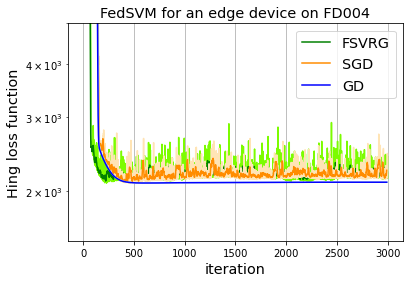

In [47]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
# plot costs
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
plt.plot(cost_FSVRG, 'lawngreen')
plt.plot(running_mean(cost_FSVRG, 10), 'g', label="FSVRG")
plt.plot(cost_SGD, 'moccasin')
plt.plot(running_mean(cost_SGD, 10), 'darkorange', label="SGD")
plt.plot(cost_GD, 'lightblue')
plt.plot(running_mean(cost_GD, 10), 'b', label="GD")
plt.legend(loc="best", fontsize="x-large")
plt.yscale('log')
plt.title("FedSVM for an edge device on FD004", fontsize="x-large")
plt.ylabel("Hing loss function", fontsize="x-large")
plt.xlabel("iteration", fontsize="x-large")
plt.grid()
plt.ylim(0, 5000)
dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/master_worker/FD004/Results/"

plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
plt.savefig("Hing loss function in FedSVM with 10 machines1 FD004.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.savefig("Hing loss function in FedSVM with 10 machines1 FD004.png", format='png', dpi=1200, bbox_inches='tight')


C:\Users\alibei\AppData\Local\Temp/ipykernel_13760/1309138016.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig[i], ax[i] = plt.subplots()


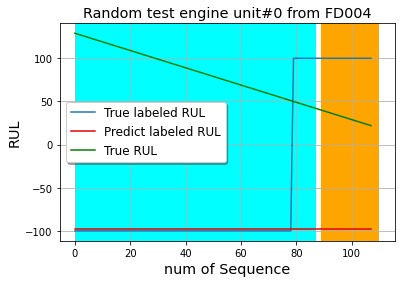

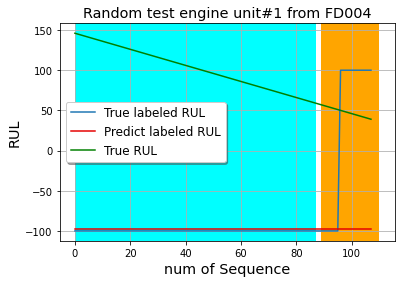

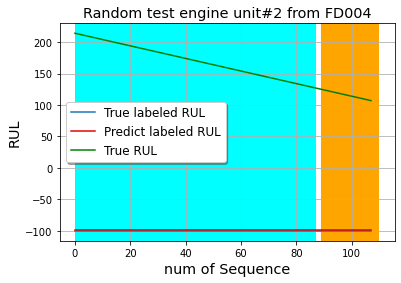

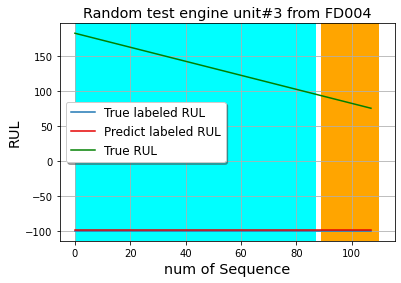

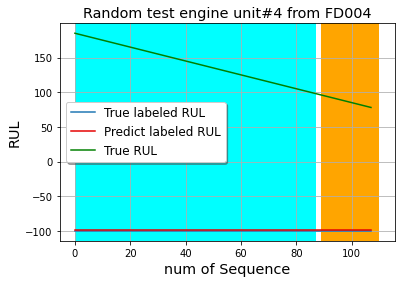

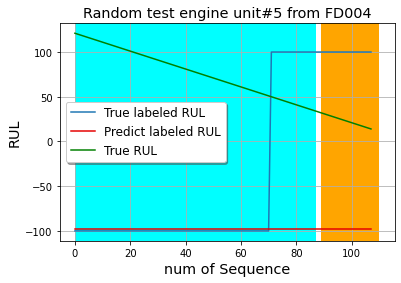

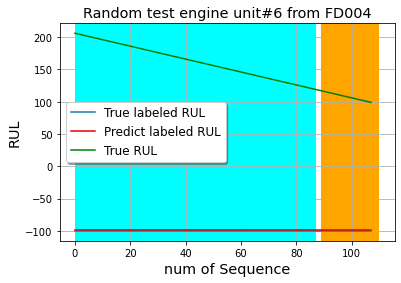

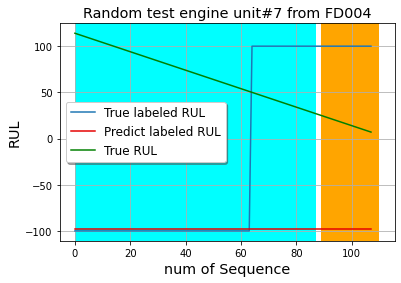

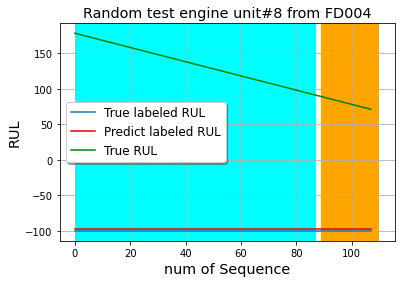

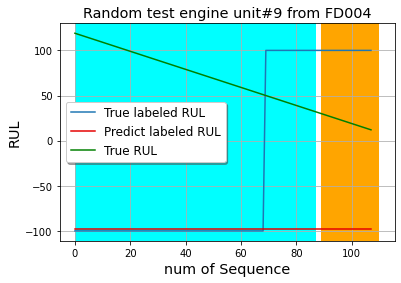

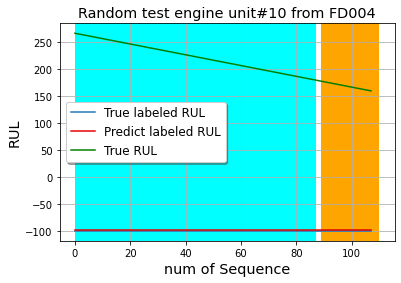

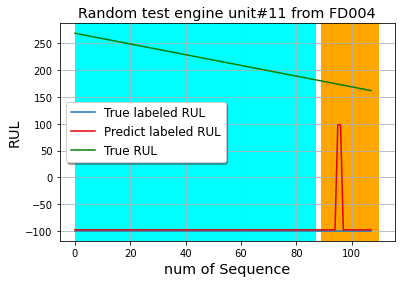

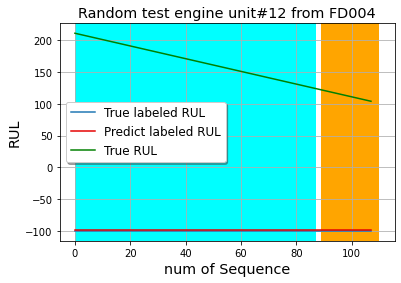

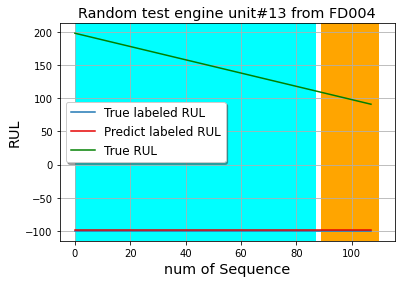

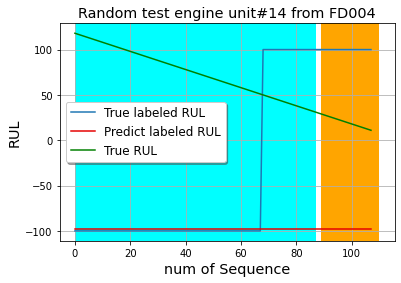

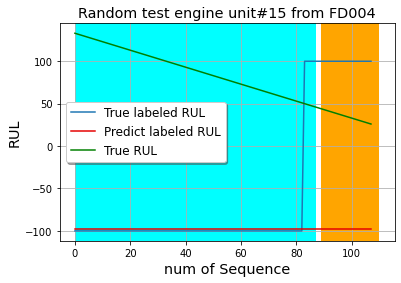

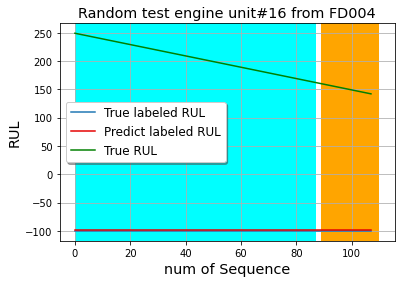

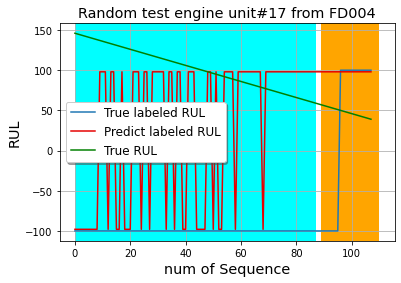

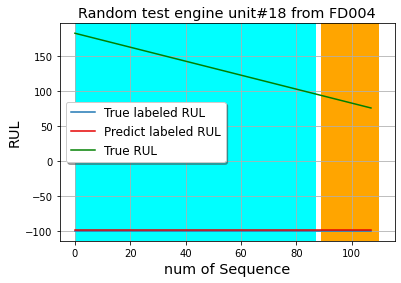

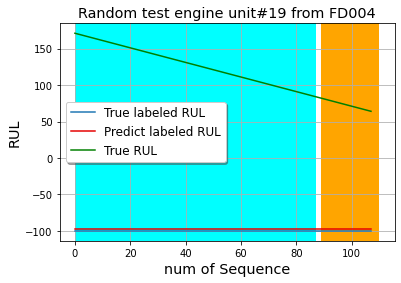

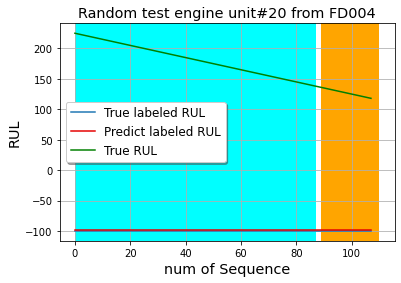

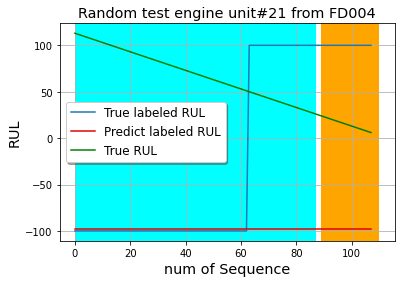

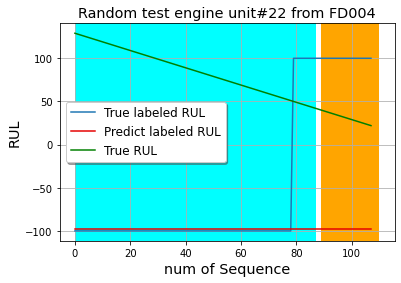

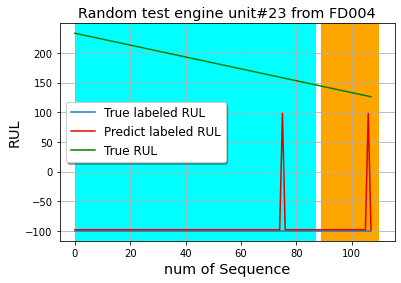

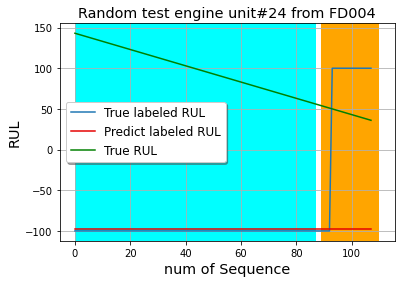

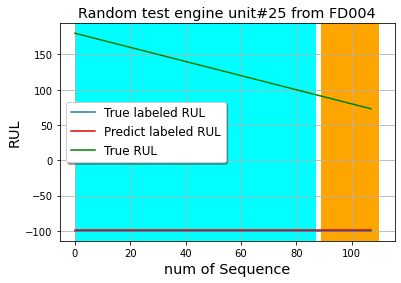

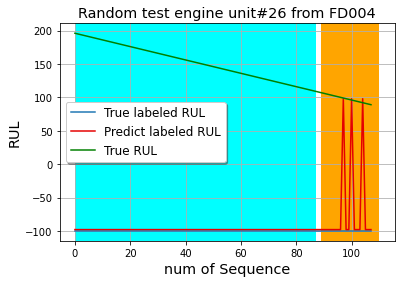

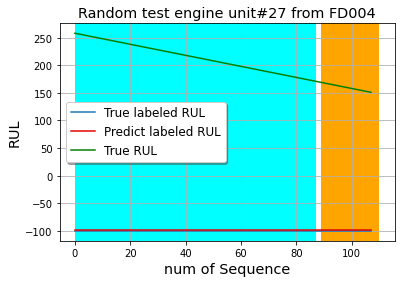

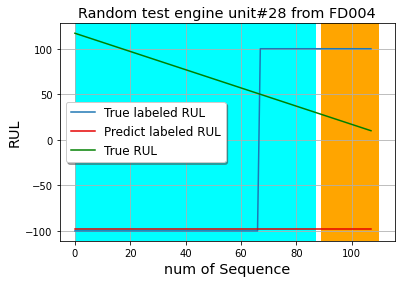

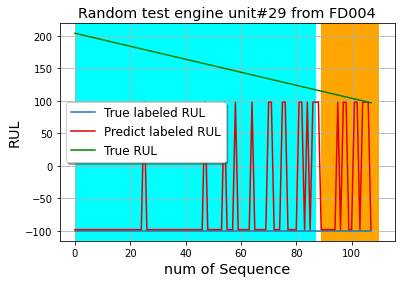

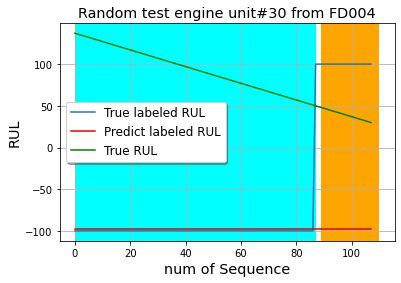

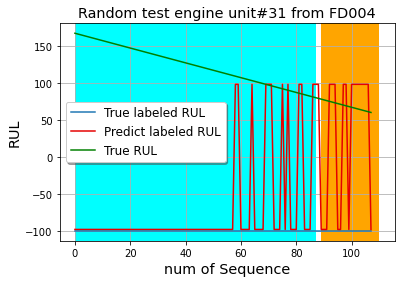

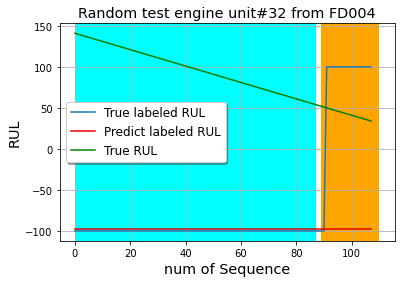

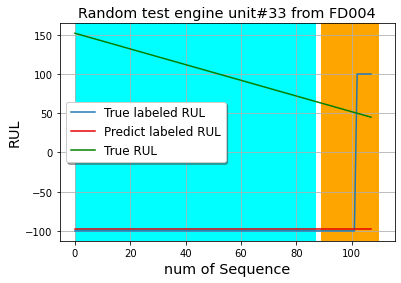

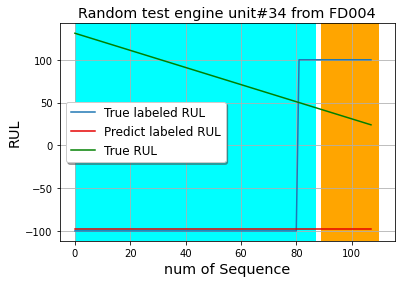

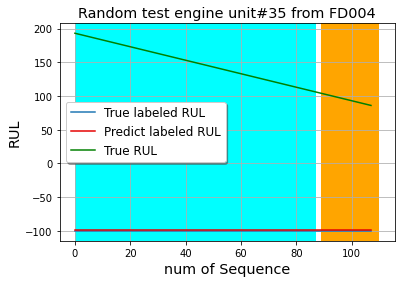

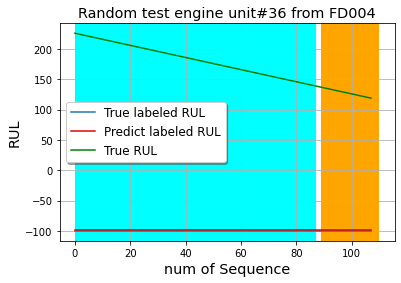

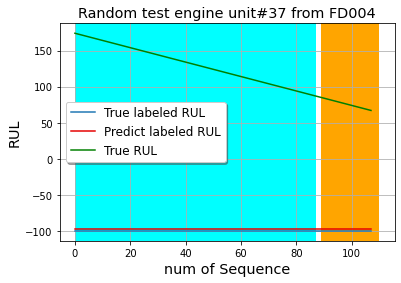

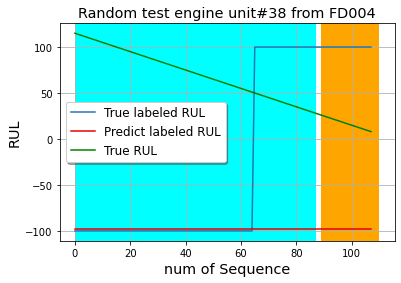

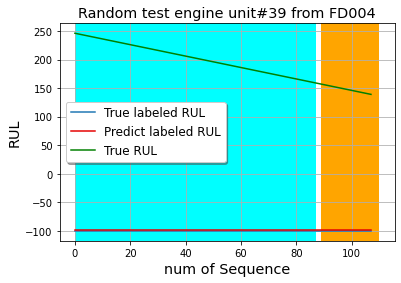

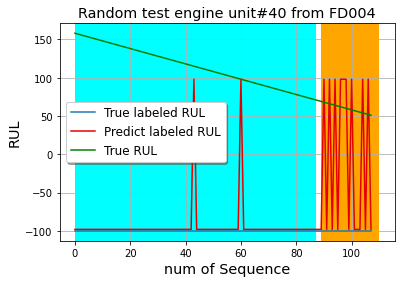

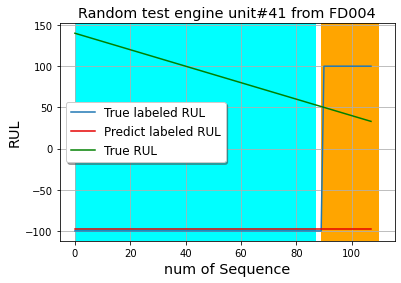

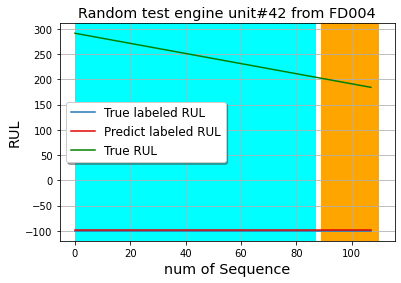

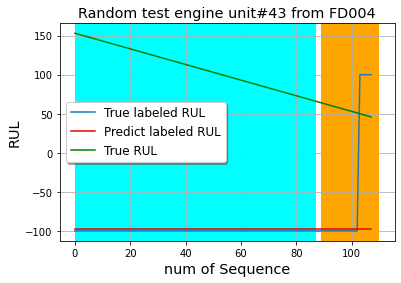

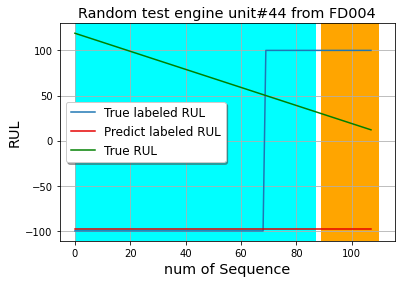

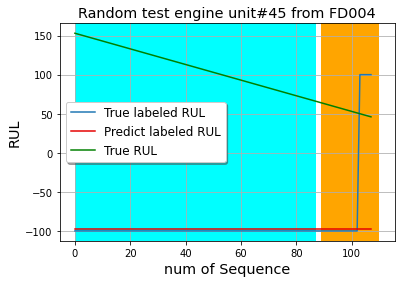

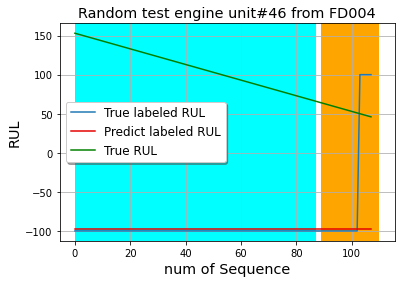

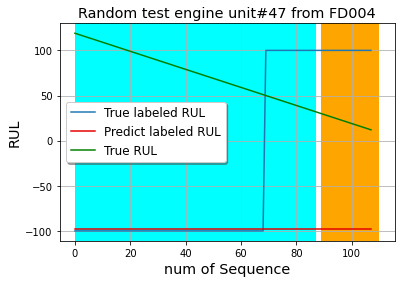

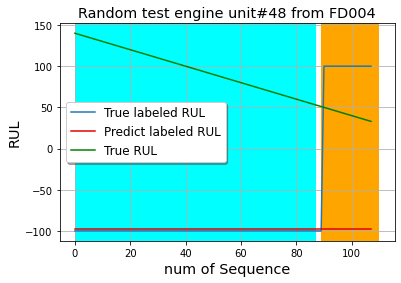

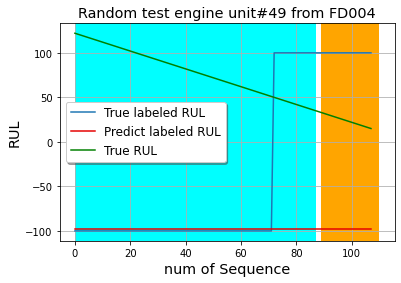

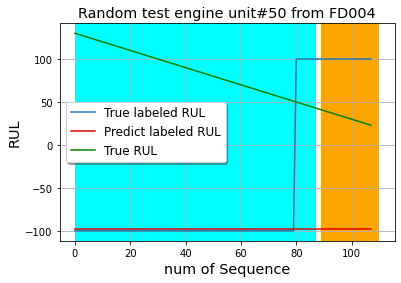

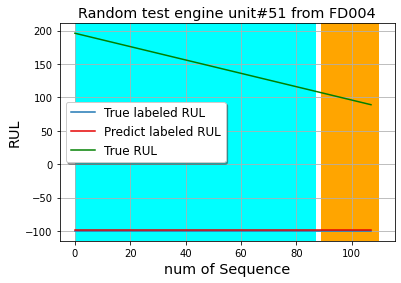

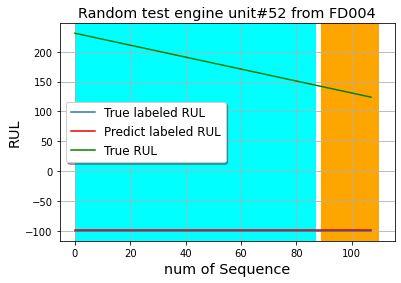

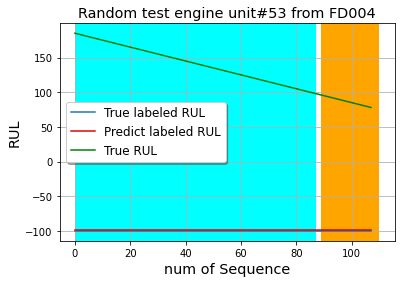

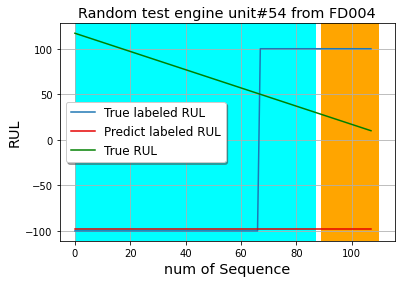

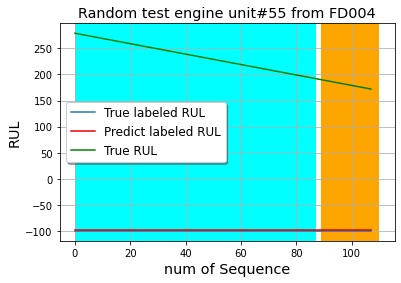

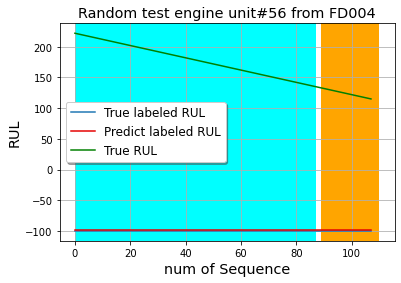

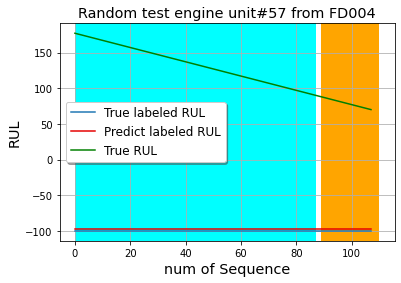

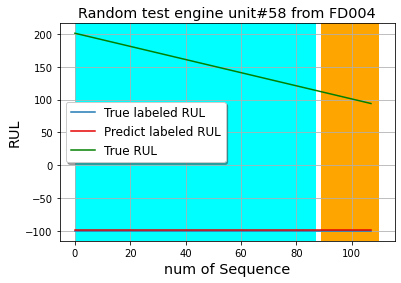

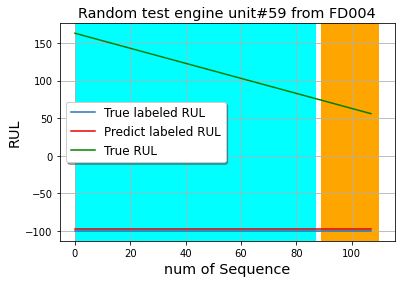

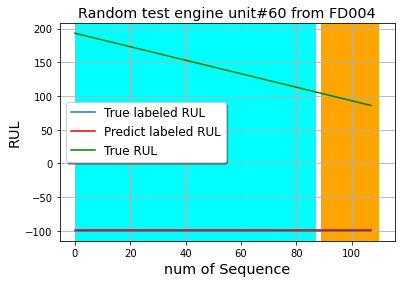

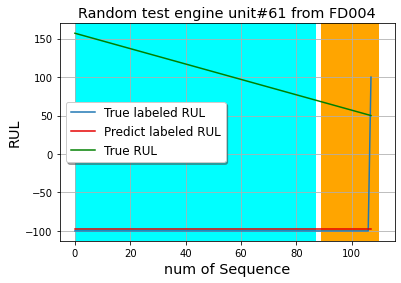

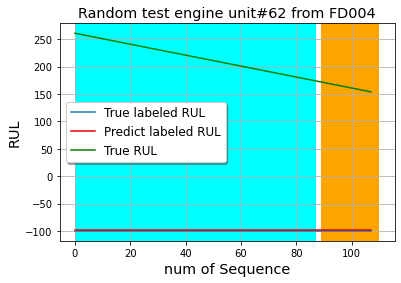

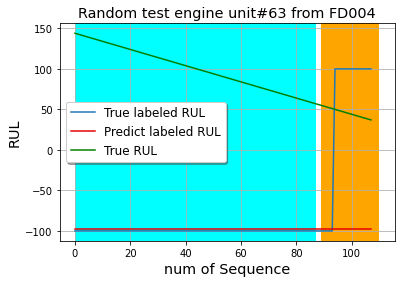

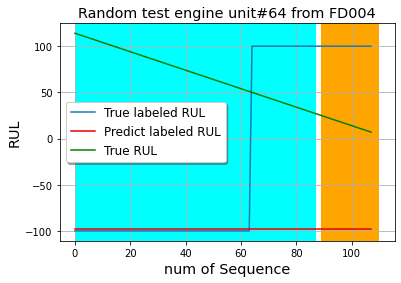

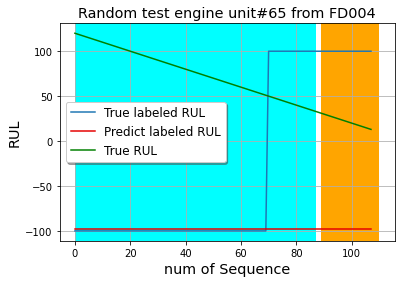

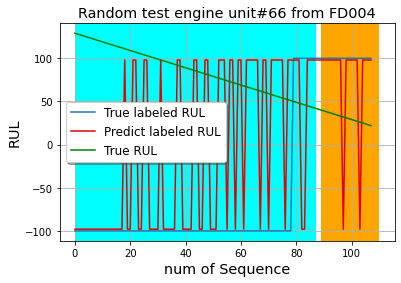

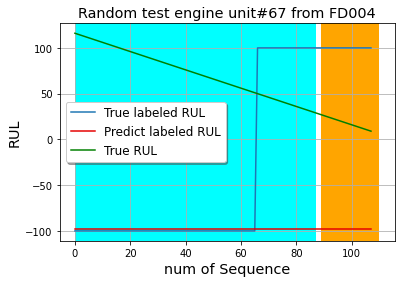

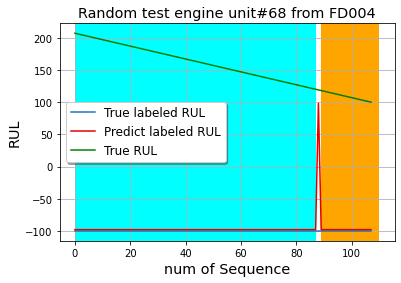

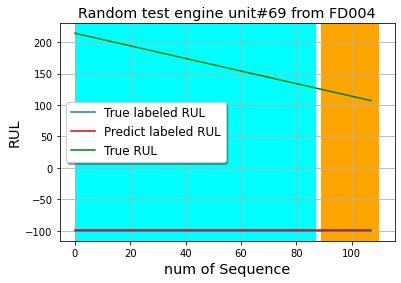

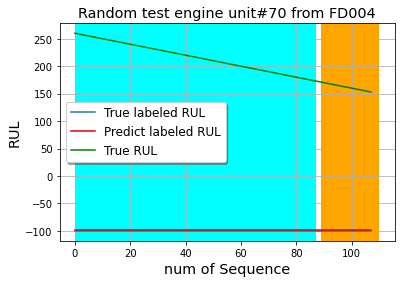

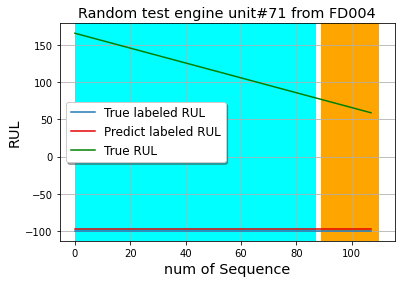

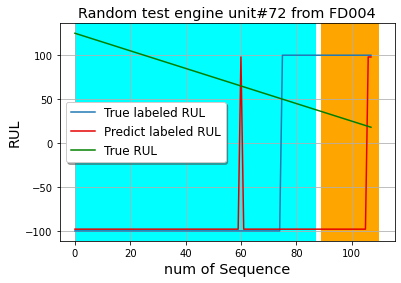

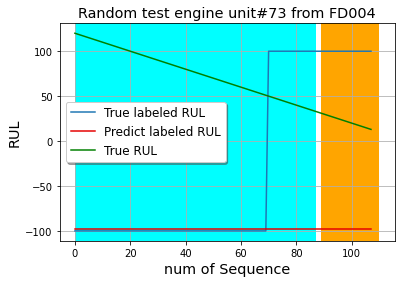

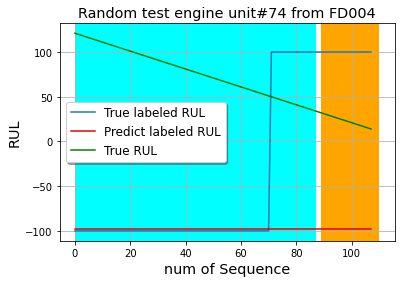

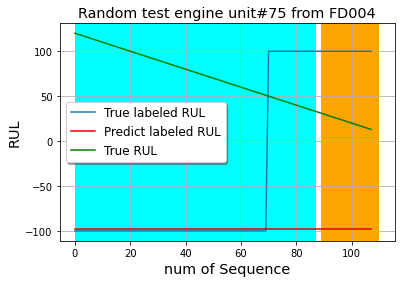

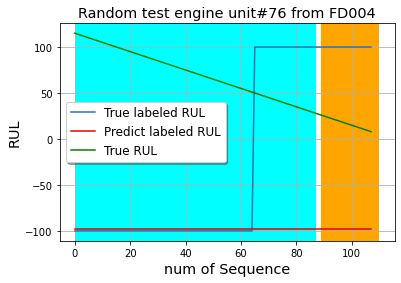

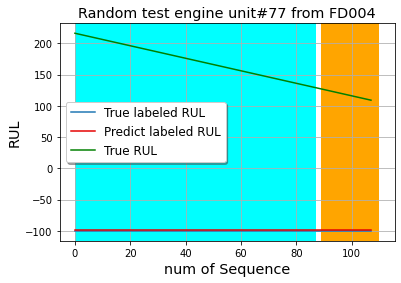

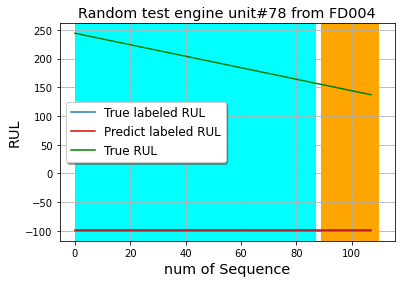

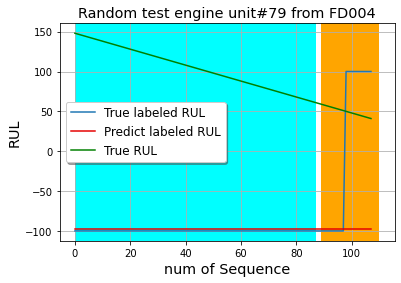

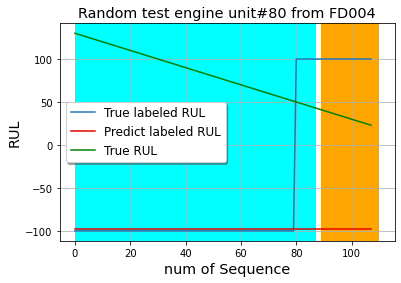

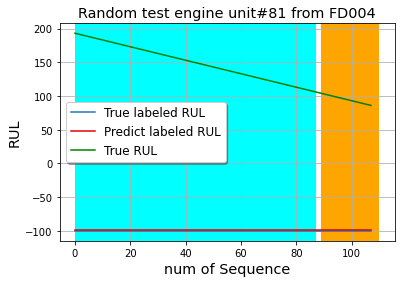

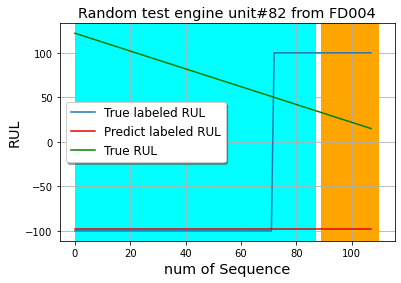

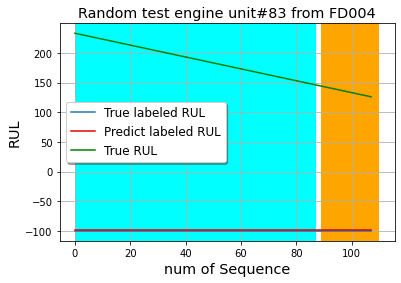

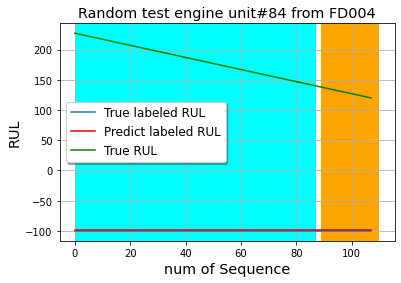

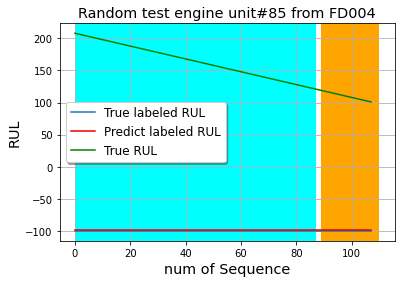

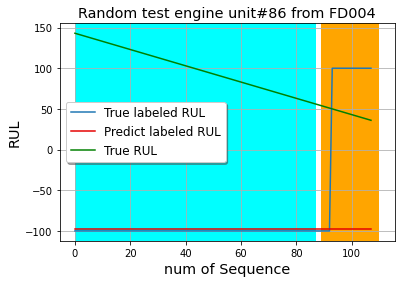

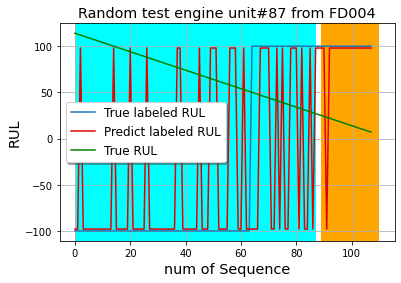

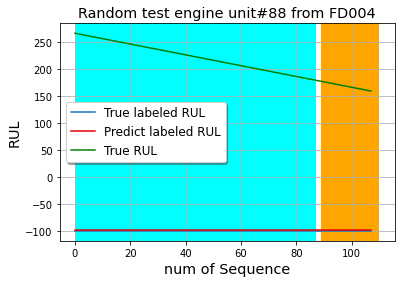

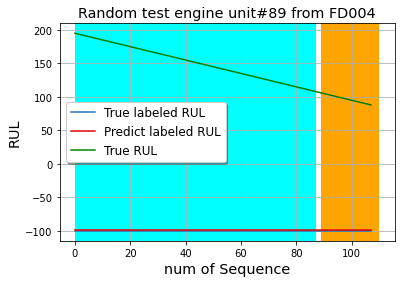

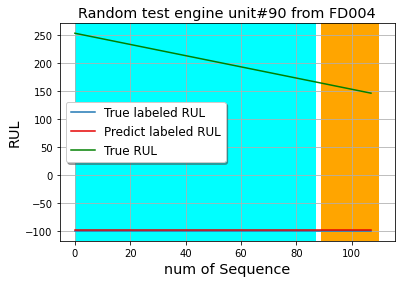

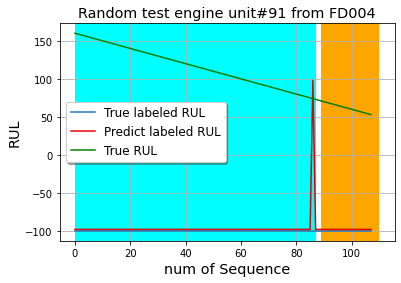

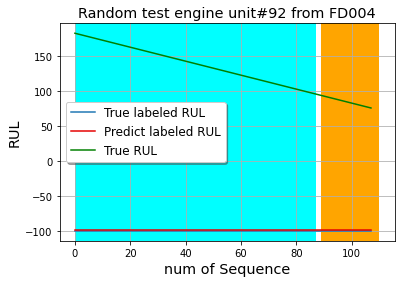

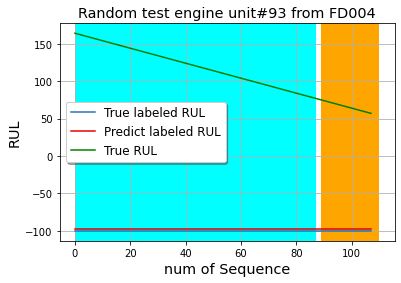

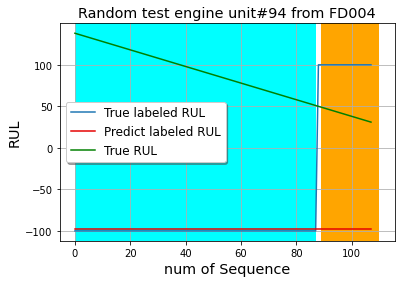

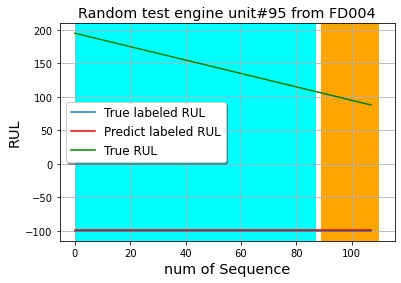

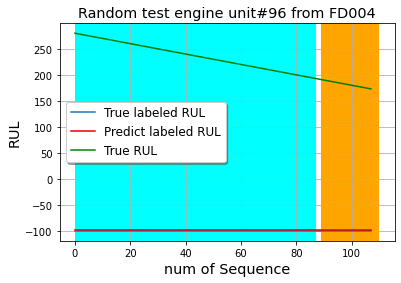

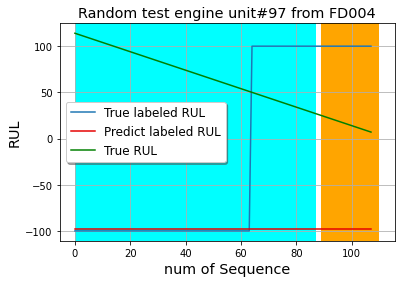

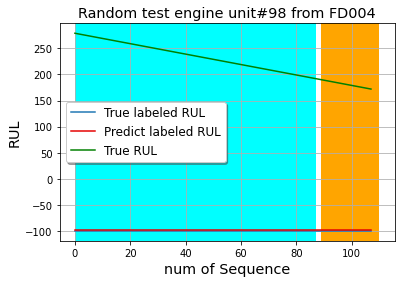

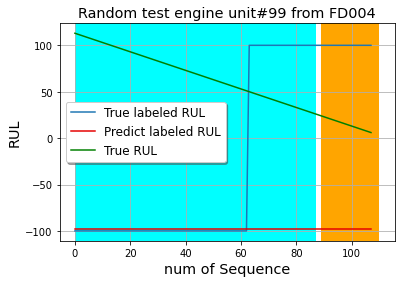

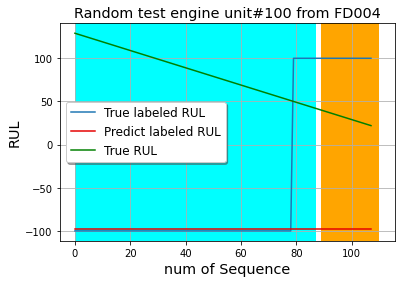

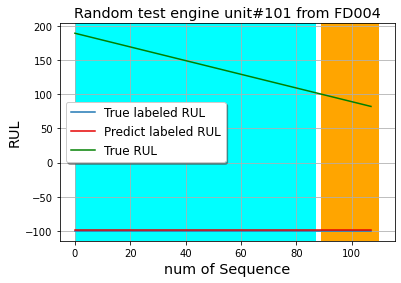

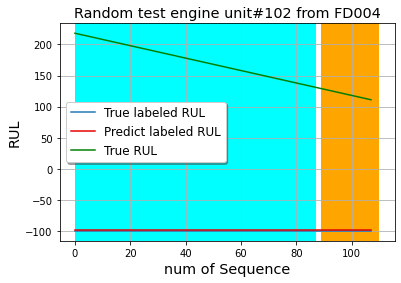

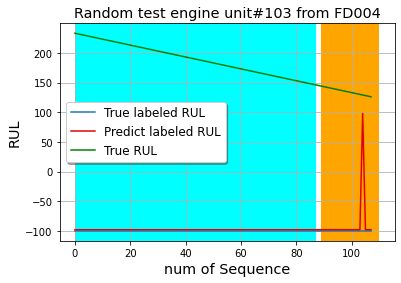

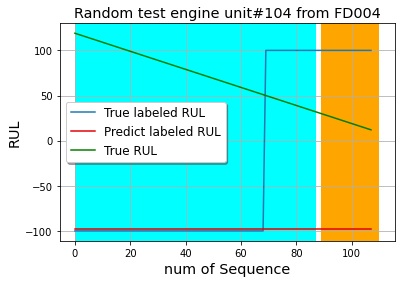

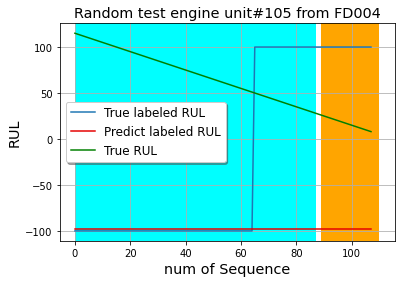

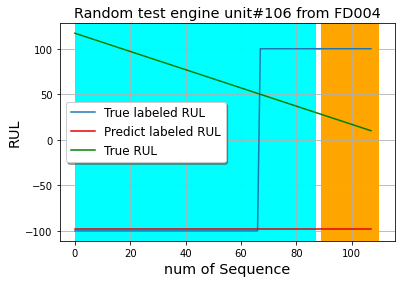

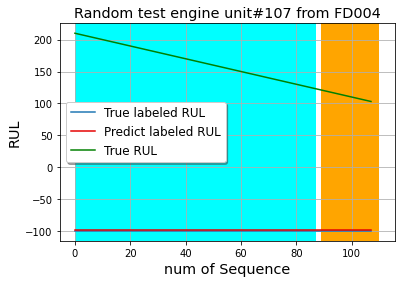

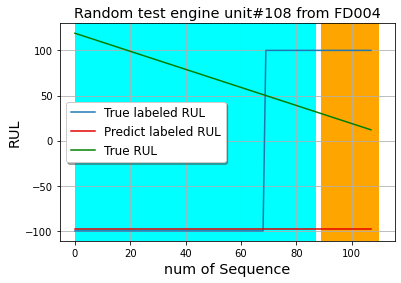

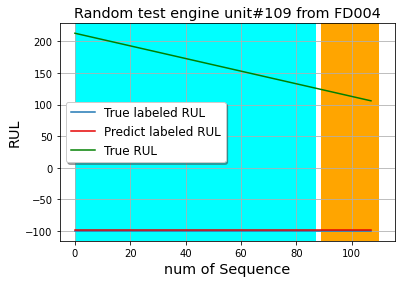

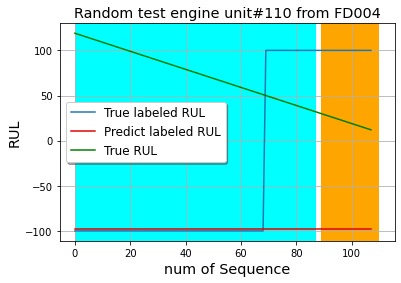

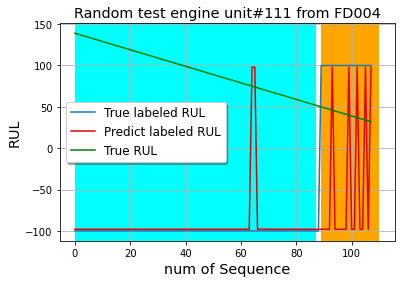

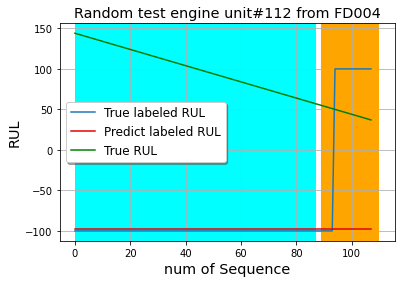

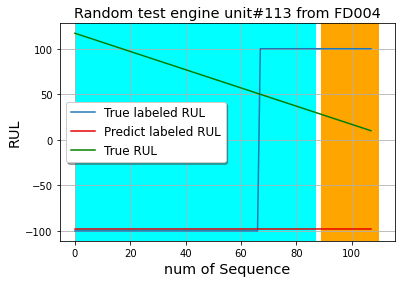

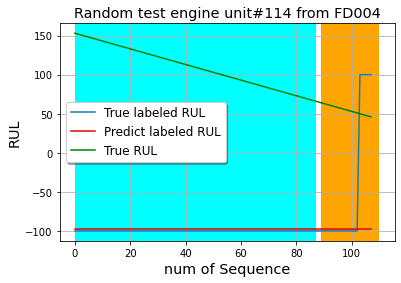

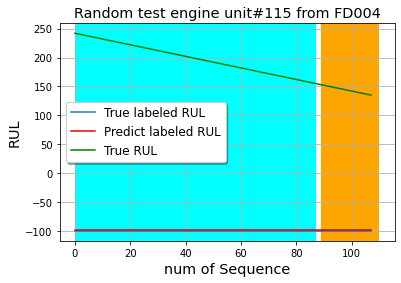

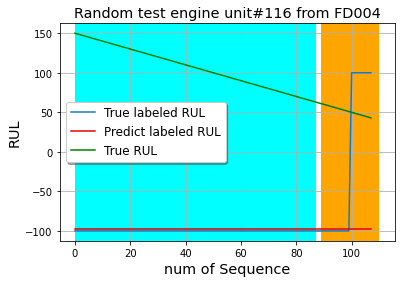

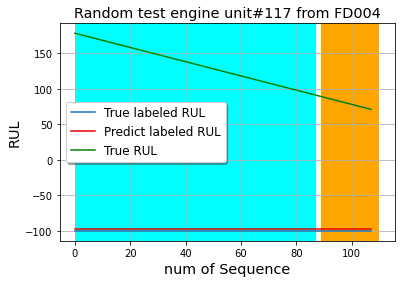

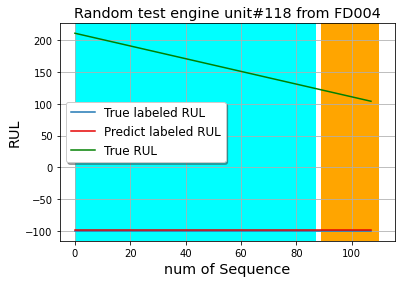

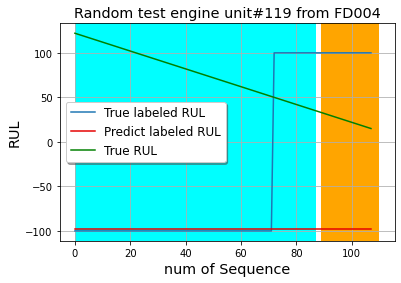

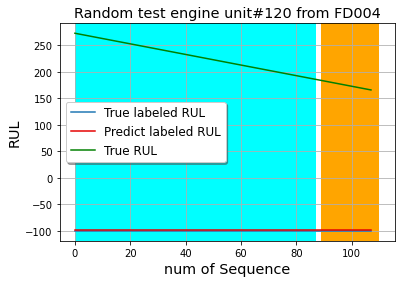

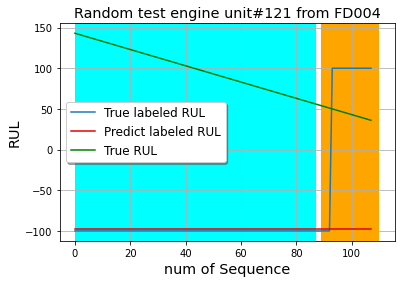

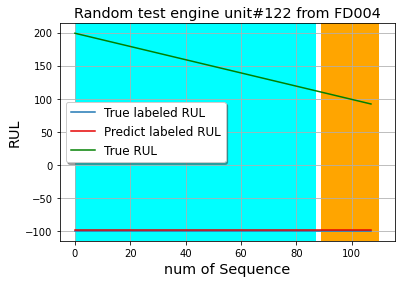

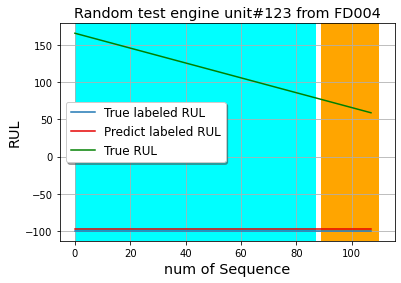

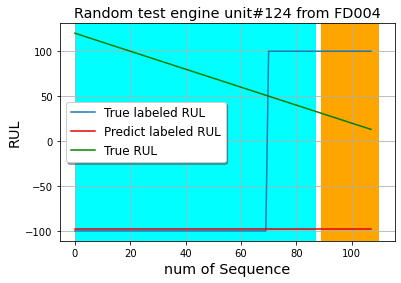

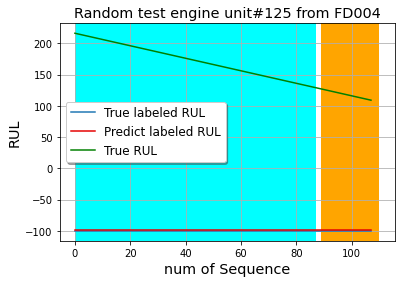

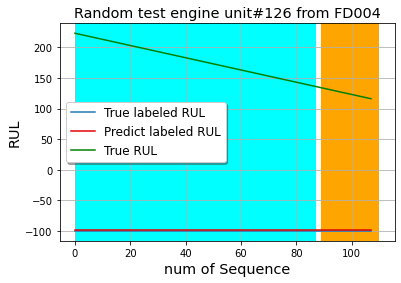

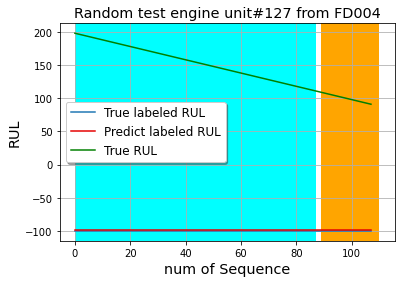

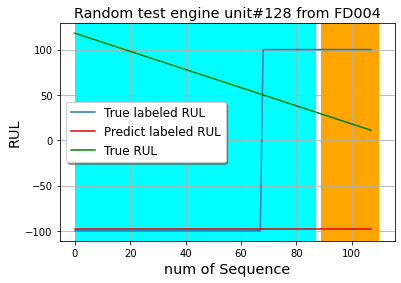

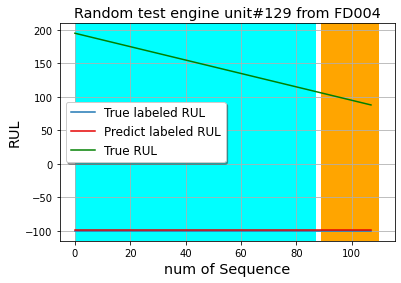

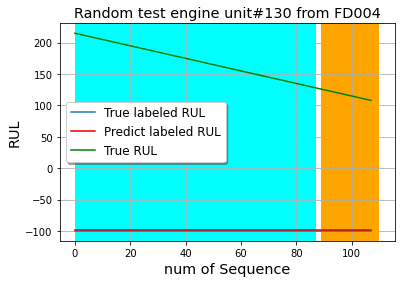

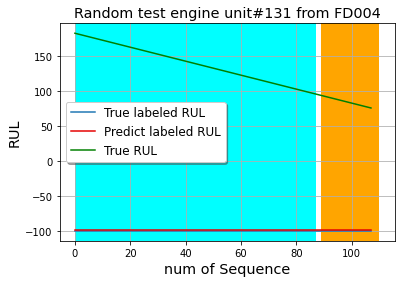

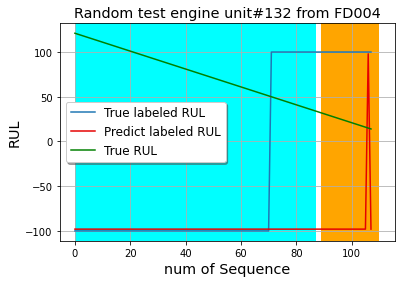

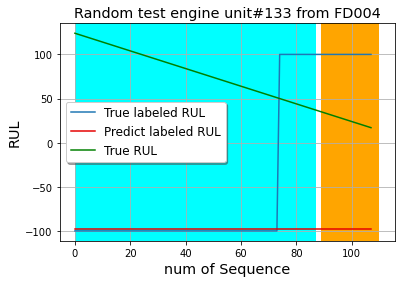

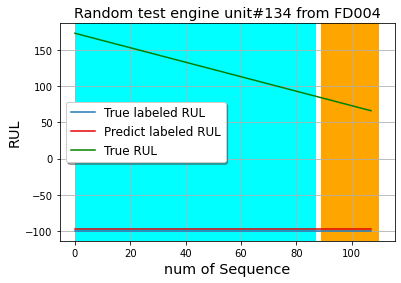

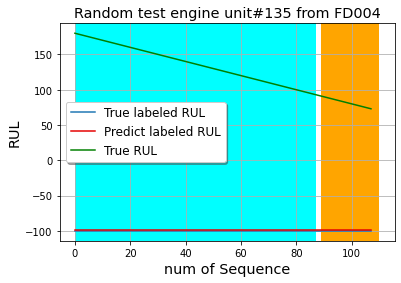

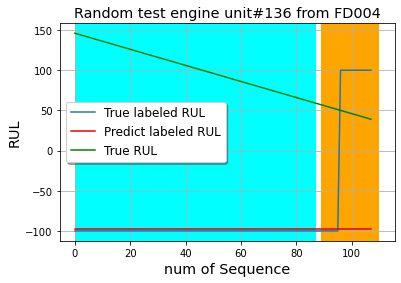

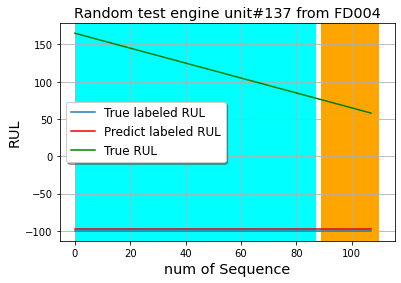

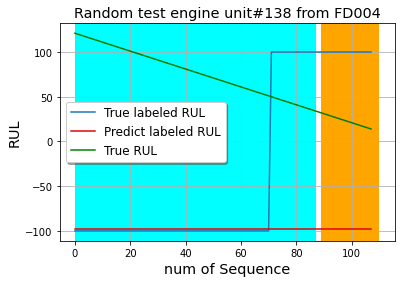

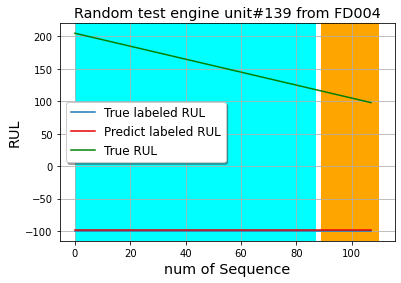

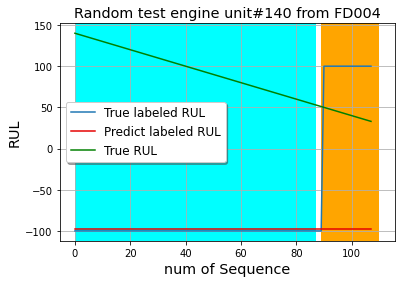

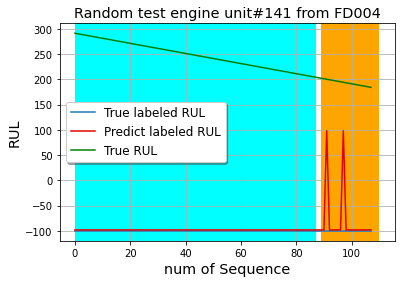

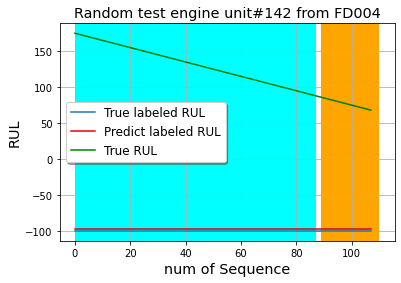

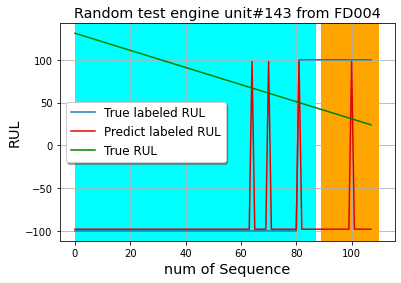

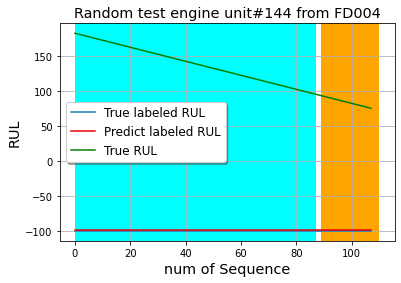

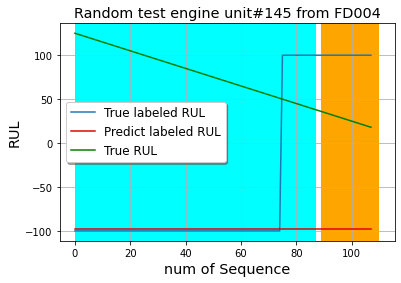

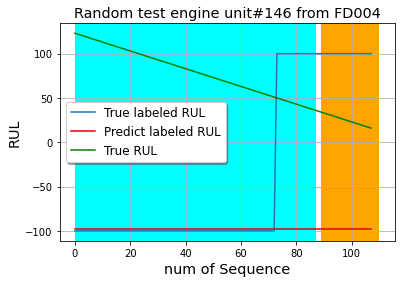

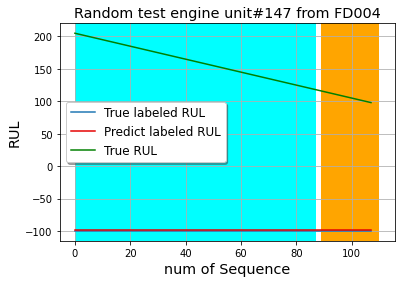

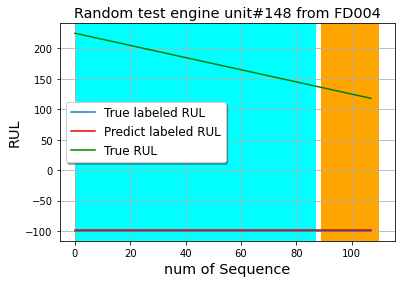

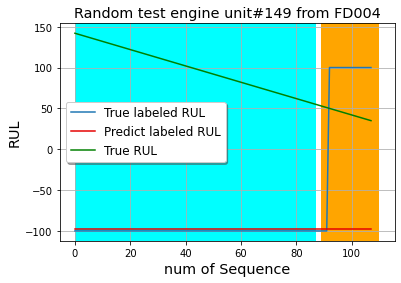

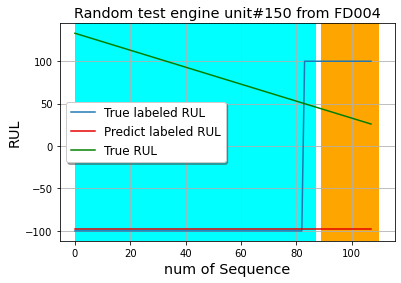

In [68]:
# Plot all the labels estimation with FedSVM for 100 master workers
fig = {}
ax = {}
for i in range(len(X_test_dic)):
    pre = predict(w_out_FSVRG, X_test_dic[i])
    fig[i], ax[i] = plt.subplots()
    ax[i].plot(Y_test_dic[i] * 100, label='True labeled RUL')
    ax[i].plot(pre * 98, label='Predict labeled RUL', color='#E50000')
    ax[i].plot(Y_test_rul_dic[i], label='True RUL', color='#008000')
    plt.title("Random test engine unit#" + str(i) + " from FD004", fontsize="x-large")
    plt.ylabel("RUL", fontsize="x-large")
    #plt.xlabel("num of Sequence generated by windowing on input dataset", fontsize="x-large")
    plt.xlabel("num of Sequence", fontsize="x-large")
    ax[i].legend(shadow=True, fontsize='large')
    ax[i].grid()
    ax[i].axvspan(89, 110, facecolor='#FFA500')
    ax[i].axvspan(0, 87, facecolor='#00FFFF')

dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/master_worker/FD004/Results/Lable prediction/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
#for i in range(len(X_test_dic)):
#    fig[i].savefig("FD004 Label prediction with FedSVM for machine number_" + str(i) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
#    fig[i].savefig("FD004 Label prediction with FedSVM for machine number_" + str(i) + ".png", format='png', dpi=1200, bbox_inches='tight')


In [70]:
# Save Specific figures
dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/master_worker/FD004/Results/Lable prediction/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
fig[111].savefig("FD004 Label prediction with FedSVM for machine number_" + str(111) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
fig[111].savefig("FD004 Label prediction with FedSVM for machine number_" + str(111) + ".png", format='png', dpi=1200, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
